# Import Library

In [1]:
import os
import math
import multiprocessing
from time import time 
import logging
import time as tim
from dotenv import load_dotenv

#Twitter API
import tweepy
from tweepy.auth import OAuthHandler

#Access ShapeFile
import fiona
import geopandas as gpd
from shapely.geometry import Point
from shapely.geometry import shape
from geopy.geocoders import Nominatim

#Sentiment Analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Exploring Data
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import plotly.graph_objects as go
from IPython.display import display

#Data Cleaning and NLP Sentiment Analysis
import re
from re import sub
import nltk
import spacy
from autocorrect import Speller
from textblob import TextBlob
from textblob import Word
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

nltk.download('vader_lexicon')
nltk.download('stopwords')
spell = Speller(lang='en')
stop = stopwords.words('english')

# Machine learning
from unidecode import unidecode
from sklearn.cluster import KMeans
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from gensim.test.utils import get_tmpfile
from gensim.models.phrases import Phrases, Phraser
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression #KNN algorithm
from sklearn.metrics import confusion_matrix #evaluation metric
from sklearn.metrics import classification_report
from sklearn import model_selection
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier #random Forest tree algorithm
from sklearn.ensemble import GradientBoostingClassifier #decision tree algorithm
from sklearn.svm import SVC #SVM algorithm

logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\vedant\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vedant\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1) Twitter API

In [2]:
#Keys to access the Twitter API
consumer_key = os.environ["API_KEY"]
consumer_secret = os.environ["API_KEY_SECRET"]
access_token = os.environ["ACCESS_TOKEN"]
access_token_secret = os.environ["ACCESS_TOKEN_SECRET"]
shapefile_path = os.environ["SHAPEFILE_PATH"]

In [3]:
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)

In [4]:
#Access Twitter API
api = tweepy.API(auth)

In [5]:
# Geocode address
geolocator = Nominatim(user_agent="geoapiExercises")

In [6]:
# load shapefile
shapefile = gpd.read_file(shapefile_path)

2) Class Structure

In [7]:
class Tweet:
  def __init__(self, tweet, sentiment):
    self.tweet = tweet
    self.sentiment = sentiment
  
  # Print Method
  def print_all(self):
    if self.tweet != None:
      print("Tweet : ",self.tweet)
      print("Sentiment : ",self.sentiment)

In [8]:
class State:
  
  def __init__(self, name,latitude,longitude):
    self.name = name
    self.hashtags = []
    self.tweets = []
    self.latitude = latitude
    self.longitude = longitude

  def add_tweet(self, tweet,sentiment):
    self.tweets.append(Tweet(tweet,sentiment))

  def add_hashtags(self, hashtags):
    self.hashtags = list(set(self.hashtags) | set(hashtags))
    
  # Print Method
  def print_all(self):
    print("State : ",self.name)
    print("Latitude : ",self.latitude)
    print("Longitude : ",self.longitude)

    for twt in self.tweets:
        twt.print_all()
    
    if self.hashtags != None:
      print("Hashtags : ",self.hashtags)  

In [9]:
class Party:
  
  def __init__(self, name,shortName):
    self.name = name  
    self.shortName = shortName
    self.States = {}
  
  def AddState(self, state):
    self.States.update({state.name:state})

  # Print Method
  def print_all(self):
    print("-------------------------------------------------")
    print("-------------------------------------------------")
    print("Name : ",self.name)
    print("ShortName : ",self.shortName)
    print("-------------------------------------------------")
    
    for state in self.States.keys():
      self.States[state].print_all()

    print("\n\n")

2.1) Initialize Class Objects

In [10]:
PartyList = []

In [11]:
PartyList.append(Party("Aam Aadmi Party","AAP"))
PartyList.append(Party("Bharatiya Janata Party","BJP"))
PartyList.append(Party("Indian National Congress","INC"))

In [12]:
with fiona.open(shapefile_path, "r") as shapefile:
    # Iterate through shapes in shapefile
    for feature in shapefile:
        # Get shape and convert to shapely object
        for party in PartyList:
            location = geolocator.geocode(str(feature['properties']["NAME_1"]))
            party.AddState(State(str(feature['properties']["NAME_1"]),location.latitude, location.longitude))
            

In [13]:
for party in PartyList:
    party.print_all()

-------------------------------------------------
-------------------------------------------------
Name :  Aam Aadmi Party
ShortName :  AAP
-------------------------------------------------
State :  Andaman and Nicobar
Latitude :  10.0001051
Longitude :  93.0000194
Hashtags :  []
State :  Andhra Pradesh
Latitude :  15.9240905
Longitude :  80.1863809
Hashtags :  []
State :  Arunachal Pradesh
Latitude :  28.0937702
Longitude :  94.5921326
Hashtags :  []
State :  Assam
Latitude :  26.4073841
Longitude :  93.2551303
Hashtags :  []
State :  Bihar
Latitude :  25.6440845
Longitude :  85.906508
Hashtags :  []
State :  Chandigarh
Latitude :  30.72984395
Longitude :  76.78414567016054
Hashtags :  []
State :  Chhattisgarh
Latitude :  21.6637359
Longitude :  81.8406351
Hashtags :  []
State :  Dadra and Nagar Haveli
Latitude :  20.2733604
Longitude :  73.0044988
Hashtags :  []
State :  Daman and Diu
Latitude :  20.718174949999998
Longitude :  70.93238341010638
Hashtags :  []
State :  Delhi
Latitud

3) Fetch Tweets

In [14]:
# Set the maximum number of tweets to collect
max_loops = 1

In [15]:
# Extract hashtags used in the tweets
def extract_hashtags(tweet):
    hashtags = []
    hashtags.extend([hashtag["text"] for hashtag in tweet.entities["hashtags"]])
    return hashtags

In [16]:
# Search for tweets containing specific keywords
for party in PartyList:
    query = party.name + " OR " + party.shortName
    for i in range(max_loops):
        search_results = api.search_tweets(q=query, lang='en',locale='en', count=10000,geocode="20.5937,78.9629,4000km")

        # Iterate through tweets and add them to the appropriate state
        #print(len(search_results))
        for tweet in search_results:
            if tweet.user.location:
                
                location = geolocator.geocode(tweet.user.location)
                print("User Location: " + tweet.user.location)
                print("Geocode Location: " + str(location))
                if location != None and str(location) != "India":
                    # Create Point object from lat and long
                    point = Point(location.longitude, location.latitude)

                    with fiona.open(shapefile_path, "r") as shapefile:
                        # Iterate through shapes in shapefile
                        for feature in shapefile:
                            # Get shape and convert to shapely object
                            shapely_shape = shape(feature["geometry"])
                            # Check if point is within shape
                            if shapely_shape.contains(point):
                                state = str(feature['properties']["NAME_1"])
                                if state in party.States: 
                                    party.States[state].add_tweet(tweet.text,"")
                                    party.States[state].add_hashtags(extract_hashtags(tweet))
                                    #print(extract_hashtags(tweet))
                
                elif str(location) == "India":
                    with fiona.open(shapefile_path, "r") as shapefile:
                        # Iterate through shapes in shapefile
                        for feature in shapefile:

                            if str(feature['properties']["NAME_1"]) == "Delhi":
                                state = str(feature['properties']["NAME_1"])
                                #print(state)
                                if state in party.States: 
                                    party.States[state].add_tweet(tweet.text,"")
                                    party.States[state].add_hashtags(extract_hashtags(tweet))

User Location: India
Geocode Location: India
User Location: Mumbai, India
Geocode Location: Mumbai, Mumbai Suburban, Maharashtra, India
User Location: India
Geocode Location: India
User Location: Hyderabad, India
Geocode Location: Hyderabad, Telangana, India
User Location: India
Geocode Location: India
User Location: Guwahati, Assam
Geocode Location: Guwahati, Kamrup Metropolitan, Assam, 781015, India
User Location: Mangalore, Karnataka, India
Geocode Location: Mangaluru, Mangaluru taluk, Dakshina Kannada district, Karnataka, 575001, India
User Location: India
Geocode Location: India
User Location: India
Geocode Location: India
User Location: India
Geocode Location: India
User Location: Hyderabad
Geocode Location: Hyderabad, Telangana, India
User Location: PUNE
Geocode Location: Pune City, Pune, Maharashtra, India
User Location: India
Geocode Location: India
User Location: Bangalore
Geocode Location: Bengaluru, Bangalore North, Bangalore Urban, Karnataka, India
User Location: Nashik, I

In [17]:
for party in PartyList:
    party.print_all()

-------------------------------------------------
-------------------------------------------------
Name :  Aam Aadmi Party
ShortName :  AAP
-------------------------------------------------
State :  Andaman and Nicobar
Latitude :  10.0001051
Longitude :  93.0000194
Hashtags :  []
State :  Andhra Pradesh
Latitude :  15.9240905
Longitude :  80.1863809
Hashtags :  []
State :  Arunachal Pradesh
Latitude :  28.0937702
Longitude :  94.5921326
Hashtags :  []
State :  Assam
Latitude :  26.4073841
Longitude :  93.2551303
Tweet :  In 2015, Swati Maliwal was appointed chair of the Delhi Commission for Women as the Aam Aadmi Party took power.

https://t.co/hPcBeBg6xm
Sentiment :  
Tweet :  The Enforcement Directorate (ED) on Thursday (March 9) arrested Aam Aadmi Party (AAP) leader and former Delhi deput… https://t.co/sgbY87Nhp7
Sentiment :  
Tweet :  The statement comes after the Aam Aadmi Party (#AAP) raised objections over Sisodia being kept in Tihar Jail number… https://t.co/aKMHKpiG7v
Sentime

In [18]:
# Initialize a new instance of the Vader Sentiment Pre-trained model
analyzer = SentimentIntensityAnalyzer()

In [19]:
# Creating Empty DataFrame and Storing it in variable df
columns = []
columns.append("Party")
for state in PartyList[0].States.keys():
    columns.append(state)
columns.append("Total_Rating")
df = pd.DataFrame(columns = columns)

In [20]:
#Display the empty Data frame
df

Empty DataFrame
Columns: [Party, Andaman and Nicobar, Andhra Pradesh, Arunachal Pradesh, Assam, Bihar, Chandigarh, Chhattisgarh, Dadra and Nagar Haveli, Daman and Diu, Delhi, Goa, Gujarat, Haryana, Himachal Pradesh, Jammu and Kashmir, Jharkhand, Karnataka, Kerala, Lakshadweep, Madhya Pradesh, Maharashtra, Manipur, Meghalaya, Mizoram, Nagaland, Odisha, Puducherry, Punjab, Rajasthan, Sikkim, Tamil Nadu, Telangana, Tripura, Uttar Pradesh, Uttarakhand, West Bengal, Total_Rating]
Index: []

[0 rows x 38 columns]

In [21]:
for party in PartyList:
    party_rating = 0
    state_count = 0;
    new_row  = []
    new_row.append(party.name)
    for state in party.States.keys():
        state_count = state_count + 1
        state_rating = 0;
        tweet_count = 0
        for tweet in party.States[state].tweets:
            tweet_count = tweet_count + 1
            score = analyzer.polarity_scores(tweet.tweet)
            #print(score)
            state_rating = state_rating + score['compound'] 
            tweet.sentiment = score

        if tweet_count != 0 :    
            party_rating = party_rating + (state_rating/tweet_count)
            print(state," Rating : ", round((state_rating/tweet_count),5))
            new_row.append(round((state_rating/tweet_count),5))
        else:
            new_row.append(0)
    
    print("\n================================")
    print(party.name," Rating : ", round((party_rating/state_count),5))
    new_row.append(round((party_rating/state_count),5))
    df.loc[len(df.index)] = new_row

Assam  Rating :  0.2337
Delhi  Rating :  0.1746
Gujarat  Rating :  0.4574
Karnataka  Rating :  0.48847
Maharashtra  Rating :  0.13715
Odisha  Rating :  0.26793
Tamil Nadu  Rating :  0.4019
Telangana  Rating :  0.6108

Aam Aadmi Party  Rating :  0.077
Andhra Pradesh  Rating :  0.6705
Assam  Rating :  0.39046
Delhi  Rating :  0.13749
Goa  Rating :  0.4019
Karnataka  Rating :  0.50067
Maharashtra  Rating :  0.33964
Meghalaya  Rating :  0.6597
Odisha  Rating :  0.30632
Tamil Nadu  Rating :  0.47332
Telangana  Rating :  0.3137
Tripura  Rating :  0.765

Bharatiya Janata Party  Rating :  0.13774
Assam  Rating :  -0.0129
Delhi  Rating :  0.09505
Goa  Rating :  0.50225
Gujarat  Rating :  0.0
Karnataka  Rating :  0.24234
Madhya Pradesh  Rating :  0.0
Maharashtra  Rating :  0.0401
Odisha  Rating :  0.0
Puducherry  Rating :  0.8516
Tamil Nadu  Rating :  0.0
Telangana  Rating :  -0.0535

Indian National Congress  Rating :  0.04625


In [22]:
#Display the Sentiment values of 3 political parties in a Data frame 
df

Party  Andaman and Nicobar  Andhra Pradesh  \
0           Aam Aadmi Party                    0          0.0000   
1    Bharatiya Janata Party                    0          0.6705   
2  Indian National Congress                    0          0.0000   

   Arunachal Pradesh    Assam  Bihar  Chandigarh  Chhattisgarh  \
0                  0  0.23370      0           0             0   
1                  0  0.39046      0           0             0   
2                  0 -0.01290      0           0             0   

   Dadra and Nagar Haveli  Daman and Diu  ...  Punjab  Rajasthan  Sikkim  \
0                       0              0  ...       0          0       0   
1                       0              0  ...       0          0       0   
2                       0              0  ...       0          0       0   

   Tamil Nadu  Telangana  Tripura  Uttar Pradesh  Uttarakhand  West Bengal  \
0     0.40190     0.6108    0.000              0            0            0   
1     0.47332     0.3137    0.765              0            0            0   
2     0.00000    -0.0535    0.000              0            0            0   

   Total_Rating  
0       0.07700  
1       0.13774  
2       0.04625  

[3 rows x 38 columns]

In [23]:
# Create a dictionary with the sentiment values for each party in each state
plot_list  = {}
for party in PartyList:
    party_rating = 0
    state_count = 0;
    plot_list[party.name] = {}
    for state in party.States.keys():
        state_count = state_count + 1
        state_rating = 0;
        tweet_count = 0
        for tweet in party.States[state].tweets:
            tweet_count = tweet_count + 1
            score = analyzer.polarity_scores(tweet.tweet)
            state_rating = state_rating + score['compound'] 
            tweet.sentiment = score

        if tweet_count != 0 :    
            party_rating = party_rating + (state_rating/tweet_count)
            print(state," Rating : ", round((state_rating/tweet_count),5))
            plot_list[party.name].update({state : round((state_rating/tweet_count),5)})
        else:
            plot_list[party.name].update({state : 0})
    
    print("\n================================")
    print(party.name," Rating : ", round((party_rating/state_count),5))
    

Assam  Rating :  0.2337
Delhi  Rating :  0.1746
Gujarat  Rating :  0.4574
Karnataka  Rating :  0.48847
Maharashtra  Rating :  0.13715
Odisha  Rating :  0.26793
Tamil Nadu  Rating :  0.4019
Telangana  Rating :  0.6108

Aam Aadmi Party  Rating :  0.077
Andhra Pradesh  Rating :  0.6705
Assam  Rating :  0.39046
Delhi  Rating :  0.13749
Goa  Rating :  0.4019
Karnataka  Rating :  0.50067
Maharashtra  Rating :  0.33964
Meghalaya  Rating :  0.6597
Odisha  Rating :  0.30632
Tamil Nadu  Rating :  0.47332
Telangana  Rating :  0.3137
Tripura  Rating :  0.765

Bharatiya Janata Party  Rating :  0.13774
Assam  Rating :  -0.0129
Delhi  Rating :  0.09505
Goa  Rating :  0.50225
Gujarat  Rating :  0.0
Karnataka  Rating :  0.24234
Madhya Pradesh  Rating :  0.0
Maharashtra  Rating :  0.0401
Odisha  Rating :  0.0
Puducherry  Rating :  0.8516
Tamil Nadu  Rating :  0.0
Telangana  Rating :  -0.0535

Indian National Congress  Rating :  0.04625


In [24]:
plot_list

{'Aam Aadmi Party': {'Andaman and Nicobar': 0,
  'Andhra Pradesh': 0,
  'Arunachal Pradesh': 0,
  'Assam': 0.2337,
  'Bihar': 0,
  'Chandigarh': 0,
  'Chhattisgarh': 0,
  'Dadra and Nagar Haveli': 0,
  'Daman and Diu': 0,
  'Delhi': 0.1746,
  'Goa': 0,
  'Gujarat': 0.4574,
  'Haryana': 0,
  'Himachal Pradesh': 0,
  'Jammu and Kashmir': 0,
  'Jharkhand': 0,
  'Karnataka': 0.48847,
  'Kerala': 0,
  'Lakshadweep': 0,
  'Madhya Pradesh': 0,
  'Maharashtra': 0.13715,
  'Manipur': 0,
  'Meghalaya': 0,
  'Mizoram': 0,
  'Nagaland': 0,
  'Odisha': 0.26793,
  'Puducherry': 0,
  'Punjab': 0,
  'Rajasthan': 0,
  'Sikkim': 0,
  'Tamil Nadu': 0.4019,
  'Telangana': 0.6108,
  'Tripura': 0,
  'Uttar Pradesh': 0,
  'Uttarakhand': 0,
  'West Bengal': 0},
 'Bharatiya Janata Party': {'Andaman and Nicobar': 0,
  'Andhra Pradesh': 0.6705,
  'Arunachal Pradesh': 0,
  'Assam': 0.39046,
  'Bihar': 0,
  'Chandigarh': 0,
  'Chhattisgarh': 0,
  'Dadra and Nagar Haveli': 0,
  'Daman and Diu': 0,
  'Delhi': 0.1374

In [25]:
colors = ['rgb(0,154,218)','rgb(249,125,9)', 'rgb(22,106,47)']
line_size = [2, 2, 2]
i = 0
for plot_one in plot_list.keys():
    # Create traces
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(plot_list[plot_one].keys()), y=list(plot_list[plot_one].values()),
                    mode='lines+markers',
                    name=plot_one,
                    line=dict(color=colors[i], width=line_size[i])))
    # Edit the layout
    fig.update_layout(title='Sentiment of ' + plot_one + ' by State',
                    xaxis_title='States',
                    yaxis_title='Sentiment Value')
    fig.show()
    i+=1

In [26]:
#Create Comparative Graph
fig = go.Figure()

for plot_one in plot_list.keys():
    # Create traces
    fig.add_trace(go.Scatter(x=list(plot_list[plot_one].keys()), y=list(plot_list[plot_one].values()),
                    mode='lines+markers',
                    name=plot_one))

# Edit the layout
fig.update_layout(title='Sentiment of Political Parties by State',
                   xaxis_title='States',
                   yaxis_title='Sentiment Value')
fig.show()

In [27]:
df

Party  Andaman and Nicobar  Andhra Pradesh  \
0           Aam Aadmi Party                    0          0.0000   
1    Bharatiya Janata Party                    0          0.6705   
2  Indian National Congress                    0          0.0000   

   Arunachal Pradesh    Assam  Bihar  Chandigarh  Chhattisgarh  \
0                  0  0.23370      0           0             0   
1                  0  0.39046      0           0             0   
2                  0 -0.01290      0           0             0   

   Dadra and Nagar Haveli  Daman and Diu  ...  Punjab  Rajasthan  Sikkim  \
0                       0              0  ...       0          0       0   
1                       0              0  ...       0          0       0   
2                       0              0  ...       0          0       0   

   Tamil Nadu  Telangana  Tripura  Uttar Pradesh  Uttarakhand  West Bengal  \
0     0.40190     0.6108    0.000              0            0            0   
1     0.47332     0.3137    0.765              0            0            0   
2     0.00000    -0.0535    0.000              0            0            0   

   Total_Rating  
0       0.07700  
1       0.13774  
2       0.04625  

[3 rows x 38 columns]

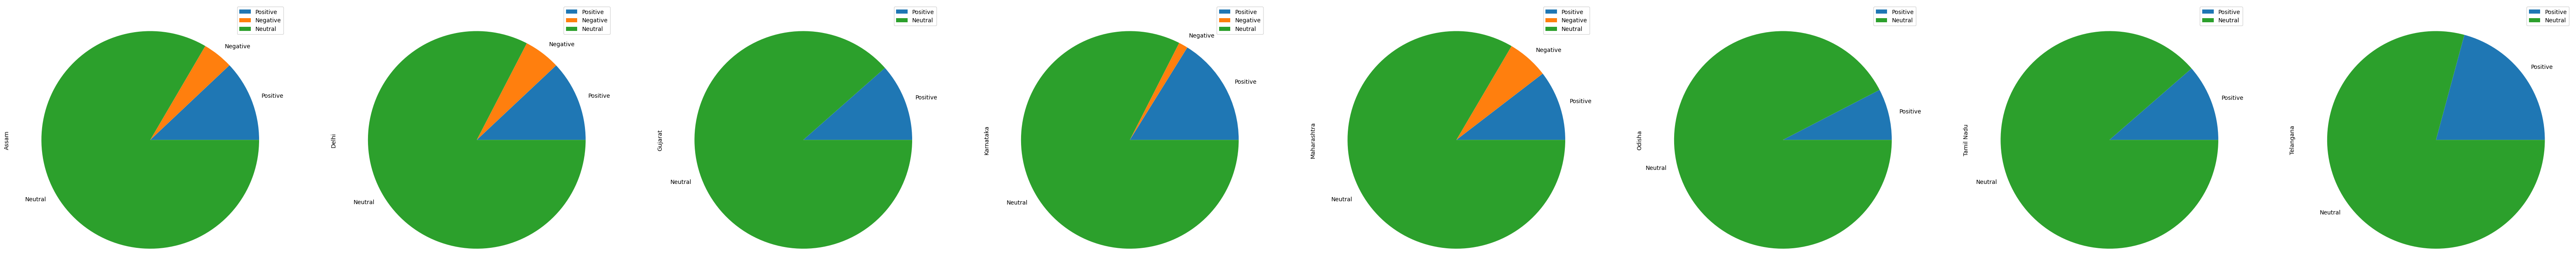

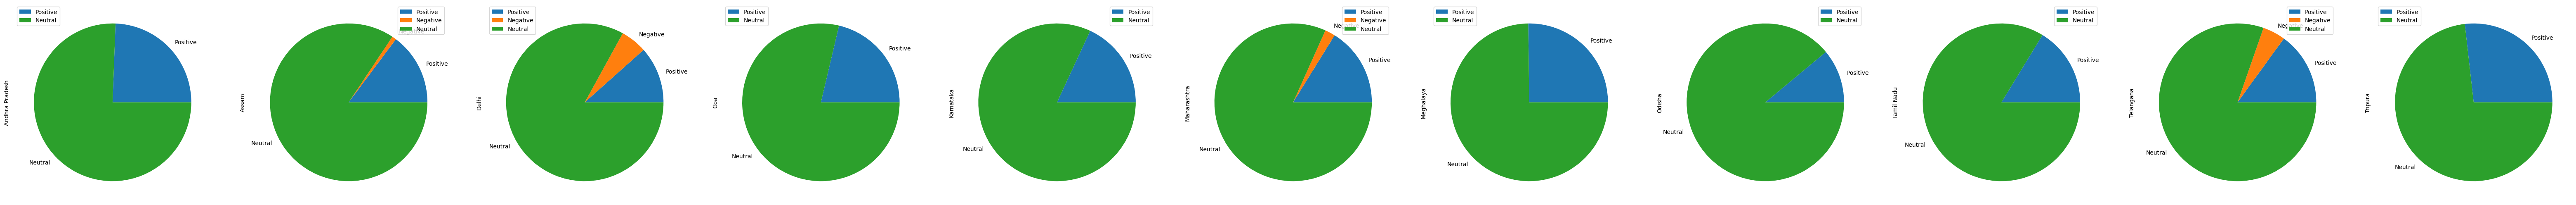

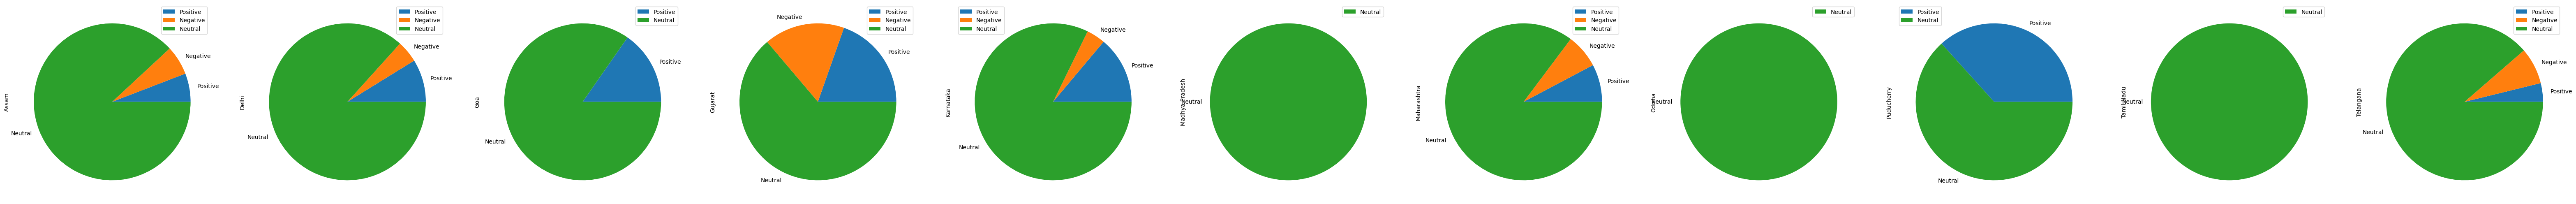

In [28]:
for party in PartyList:
    dictin = {}
    arrpo = []
    arrne = []
    arrnu = []
    stateidx = []
    party_rating = 0
    state_count = 0
    for state in party.States.keys():
        state_count = state_count + 1
        state_rating_po = 0;
        state_rating_ne = 0;
        state_rating_nu = 0;
        tweet_count = 0
        for tweet in party.States[state].tweets:
            tweet_count = tweet_count + 1
            score = analyzer.polarity_scores(tweet.tweet)
            state_rating_po += score['pos']
            state_rating_ne += score['neg']
            state_rating_nu += score['neu'] 
            tweet.sentiment = score

        if tweet_count != 0 :    
            party_rating = party_rating + (state_rating/tweet_count)
            arrpo.append(round((state_rating_po/tweet_count),5))
            arrne.append(round((state_rating_ne/tweet_count),5))
            arrnu.append(round((state_rating_nu/tweet_count),5))
            stateidx.append(state)
        
    dictin.update({'Positive':arrpo})
    dictin.update({'Negative':arrne})
    dictin.update({'Neutral':arrnu})

    df = pd.DataFrame(dictin, index=stateidx)
    df.T.plot.pie(subplots=True, figsize=(80, 10))    

In [29]:
df_coll  = {}

In [30]:
df_coll  = {}

for party in PartyList:
    
    # create an Empty DataFrame object
    df_temp = pd.DataFrame(columns=['Tweet','Party','State','Latitude','Longitude'])
    
    for state in party.States.keys():
        for tweet in party.States[state].tweets:
            df_temp.loc[len(df_temp.index)] = [tweet.tweet,party.shortName,party.States[state].name,party.States[state].latitude,party.States[state].longitude]
            
    df_coll.update({party.name : df_temp})

In [31]:
df_coll

{'Aam Aadmi Party':                                                 Tweet Party      State  \
 0   In 2015, Swati Maliwal was appointed chair of ...   AAP      Assam   
 1   The Enforcement Directorate (ED) on Thursday (...   AAP      Assam   
 2   The statement comes after the Aam Aadmi Party ...   AAP      Assam   
 3   #SukeshChandrashekhar claimed that along with ...   AAP      Delhi   
 4   Aam Aadmi Party launches month-long membership...   AAP      Delhi   
 ..                                                ...   ...        ...   
 92  Allegedly, Bharat Rashtra Samithi (BRS) MLC K ...   AAP  Telangana   
 93  New Delhi: Delhi’s Rouse Avenue Court on Frida...   AAP  Telangana   
 94  Allegedly, Bharat Rashtra Samithi (BRS) MLC K ...   AAP  Telangana   
 95  Allegedly, Bharat Rashtra Samithi (BRS) MLC K ...   AAP  Telangana   
 96  Allegedly, Bharat Rashtra Samithi (BRS) MLC K ...   AAP  Telangana   
 
      Latitude  Longitude  
 0   26.407384  93.255130  
 1   26.407384  93.2551

In [32]:

count_tst = 0

for party in PartyList:
    
    # create an Empty DataFrame object
    df_temp = pd.DataFrame(columns=['Tweet'])
    
    for state in party.States.keys():
        count_tst +=  len(party.States[state].tweets)
        

print(count_tst)
    


285


In [33]:
for party in df_coll.keys():
    print(party)
    print(df_coll[party].head(5)) 
    print('-------------------------------------------------------------------')

Aam Aadmi Party
                                               Tweet Party  State   Latitude  \
0  In 2015, Swati Maliwal was appointed chair of ...   AAP  Assam  26.407384   
1  The Enforcement Directorate (ED) on Thursday (...   AAP  Assam  26.407384   
2  The statement comes after the Aam Aadmi Party ...   AAP  Assam  26.407384   
3  #SukeshChandrashekhar claimed that along with ...   AAP  Delhi  28.651718   
4  Aam Aadmi Party launches month-long membership...   AAP  Delhi  28.651718   

   Longitude  
0  93.255130  
1  93.255130  
2  93.255130  
3  77.221939  
4  77.221939  
-------------------------------------------------------------------
Bharatiya Janata Party
                                               Tweet Party           State  \
0  Heartiest Birthday Greetings to the Bharatiya ...   BJP  Andhra Pradesh   
1  Attended the Bharatiya Janata Party (BJP) Goal...   BJP           Assam   
2  Attended the Bharatiya Janata Party (BJP) Goal...   BJP           Assam   
3  Bharati

In [34]:
for party in df_coll.keys():
    df = df_coll[party]
    df['Clean_Tweet'] = df['Tweet'].apply(lambda x: " ".join(x.lower() for
                        x in x.split()))
    df['Clean_Tweet'] = df['Clean_Tweet'].str.replace('[^\w\s]', "")
    df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda x: " ".join(x for x in
                    x.split() if x not in stop))
    df['Clean_Tweet'] = df['Clean_Tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\1983491084.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\1983491084.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\1983491084.py:5: FutureWarning:

The default value of regex will change from True to False in a future version.



In [35]:
for party in df_coll.keys():
    print(df_coll[party].info())
    #print(df_coll[party].count())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97 entries, 0 to 96
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tweet        97 non-null     object 
 1   Party        97 non-null     object 
 2   State        97 non-null     object 
 3   Latitude     97 non-null     float64
 4   Longitude    97 non-null     float64
 5   Clean_Tweet  97 non-null     object 
dtypes: float64(2), object(4)
memory usage: 5.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 92
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tweet        93 non-null     object 
 1   Party        93 non-null     object 
 2   State        93 non-null     object 
 3   Latitude     93 non-null     float64
 4   Longitude    93 non-null     float64
 5   Clean_Tweet  93 non-null     object 
dtypes: float64(2), object(4)
memory usage: 5.1+ KB
None
<class 'pa

# Exploratory data analysis using WordCloud


In [36]:
# Calculating all polarity scores 
for party in df_coll.keys():
    df_coll[party]["Positive"] = [analyzer.polarity_scores(i)["pos"] for i in df_coll[party]["Clean_Tweet"]]
    df_coll[party]["Negative"] = [analyzer.polarity_scores(i)["neg"] for i in df_coll[party]["Clean_Tweet"]]
    df_coll[party]["Neutral"] = [analyzer.polarity_scores(i)["neu"] for i in df_coll[party]["Clean_Tweet"]]
    df_coll[party]['Compound'] = [analyzer.polarity_scores(i)["compound"] for i in df_coll[party]["Clean_Tweet"]]

    score = df_coll[party]['Compound'].values
    sentiment = []
    for i in score:
        if i >= 0.05 :
            sentiment.append('Positive')
        elif i <= -0.05 :
            sentiment.append('Negative')
        else:
            sentiment.append('Neutral')
    df_coll[party]["Sentiment"] = sentiment

    print("----------------------------------------------------")
    print("Party Name: " + party)
    print(df_coll[party]["Sentiment"].value_counts())

----------------------------------------------------
Party Name: Aam Aadmi Party
Positive    73
Neutral     13
Negative    11
Name: Sentiment, dtype: int64
----------------------------------------------------
Party Name: Bharatiya Janata Party
Positive    72
Neutral     11
Negative    10
Name: Sentiment, dtype: int64
----------------------------------------------------
Party Name: Indian National Congress
Positive    43
Neutral     32
Negative    20
Name: Sentiment, dtype: int64


                          Positive  Negative  Neutral
Aam Aadmi Party                 73        11       13
Bharatiya Janata Party          72        10       11
Indian National Congress        43        20       32


array([<AxesSubplot: ylabel='Aam Aadmi Party'>,
       <AxesSubplot: ylabel='Bharatiya Janata Party'>,
       <AxesSubplot: ylabel='Indian National Congress'>], dtype=object)

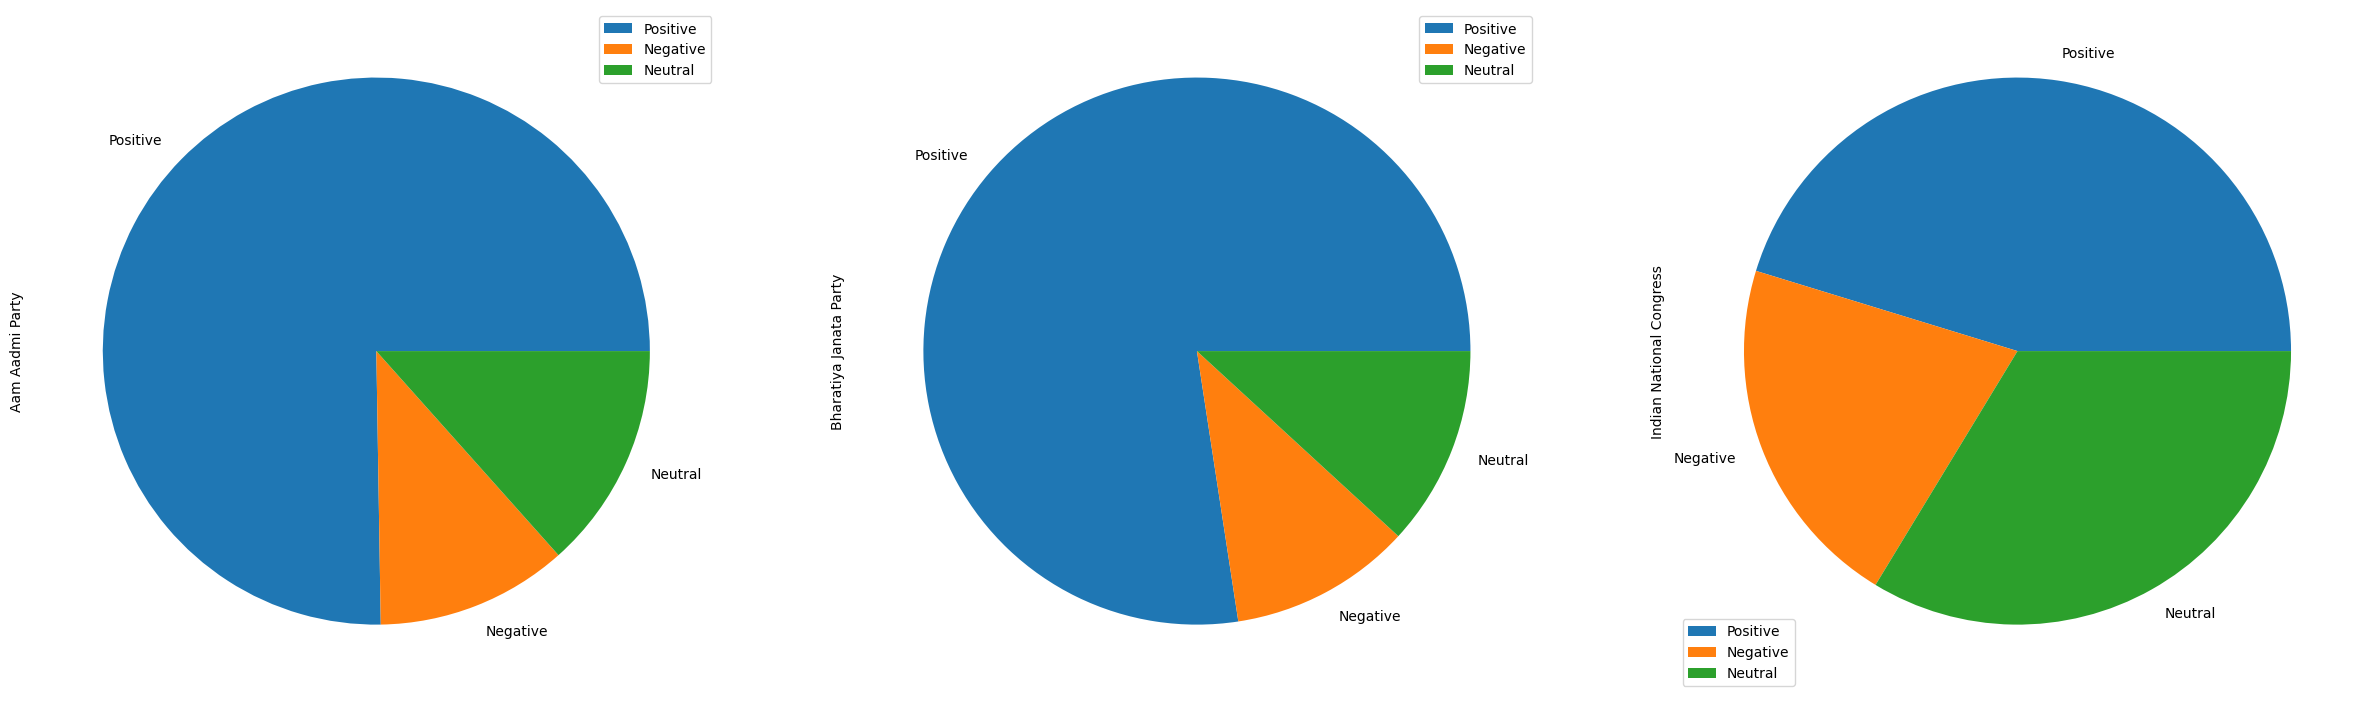

In [37]:
dictn = {}
pos_lst = []
neg_lst = []
neu_lst = []
idx = []

for party in df_coll.keys():
    dictn = {}
    idx.append(party)
    pos_lst.append(df_coll[party]["Sentiment"].value_counts()['Positive'])
    neg_lst.append(df_coll[party]["Sentiment"].value_counts()['Negative'])
    neu_lst.append(df_coll[party]["Sentiment"].value_counts()['Neutral'])

dictn.update({'Positive':pos_lst})
dictn.update({'Negative':neg_lst})
dictn.update({'Neutral':neu_lst})
df_n = pd.DataFrame(dictn,index=idx)
print(df_n)

df_n.T.plot.pie(subplots=True, figsize=(30, 20)) 

In [38]:
def wordCloudPrint(words,sentiment,party):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                        background_color='black',
                        colormap='Paired',
                        width=3000,
                        height=2500
                        ).generate(words)
    plt.figure(1,figsize=(12, 12))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title('Reviews with '+sentiment+' Sentiments ('+ party +')',fontsize=25)
    plt.show()

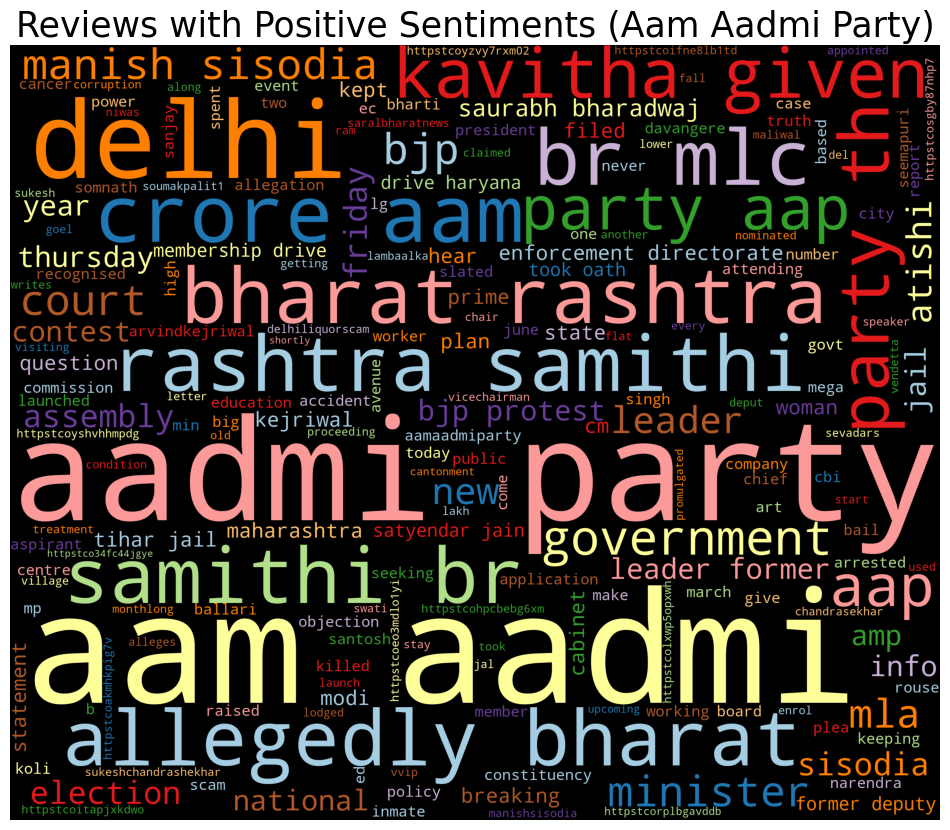

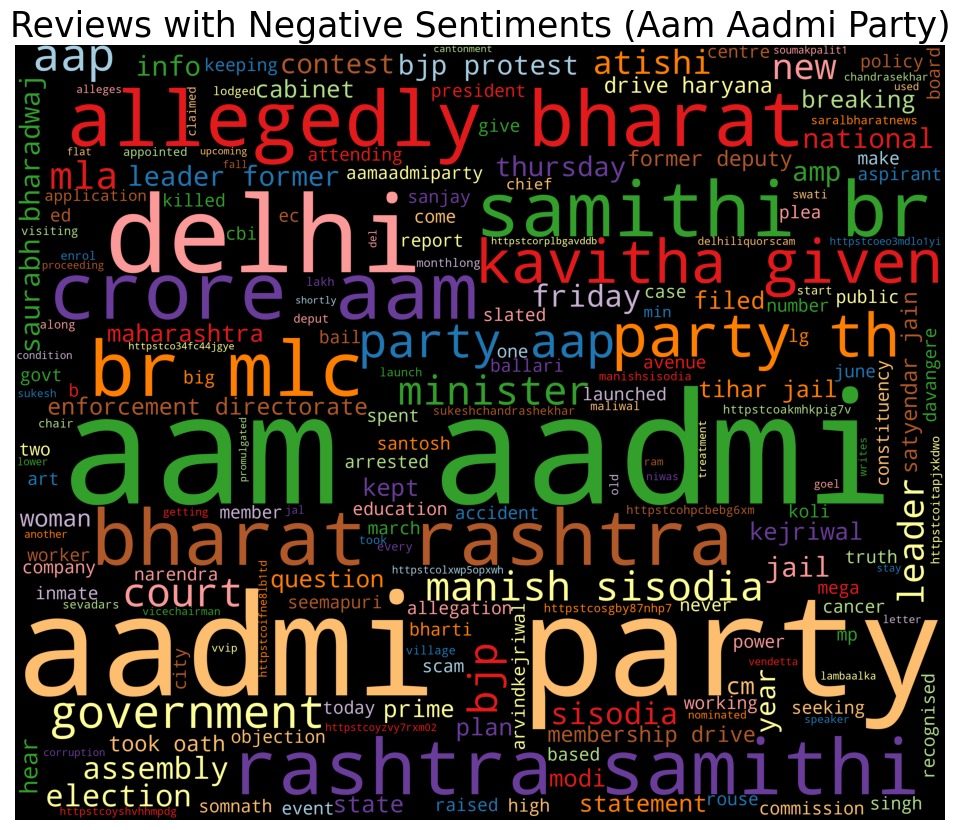

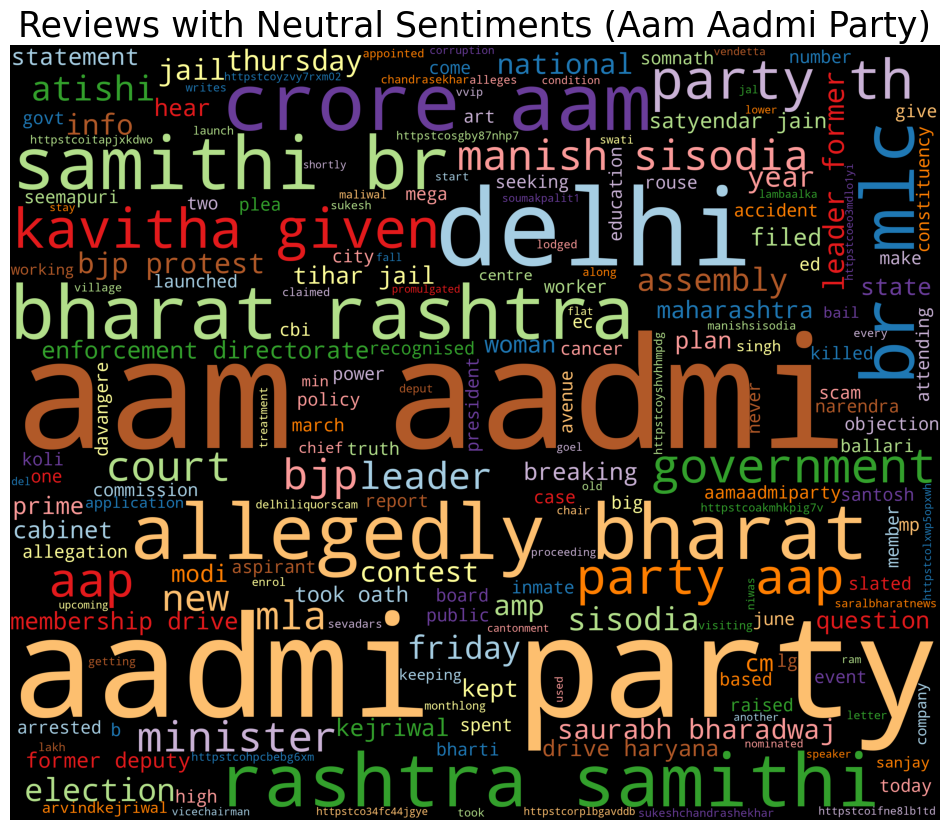

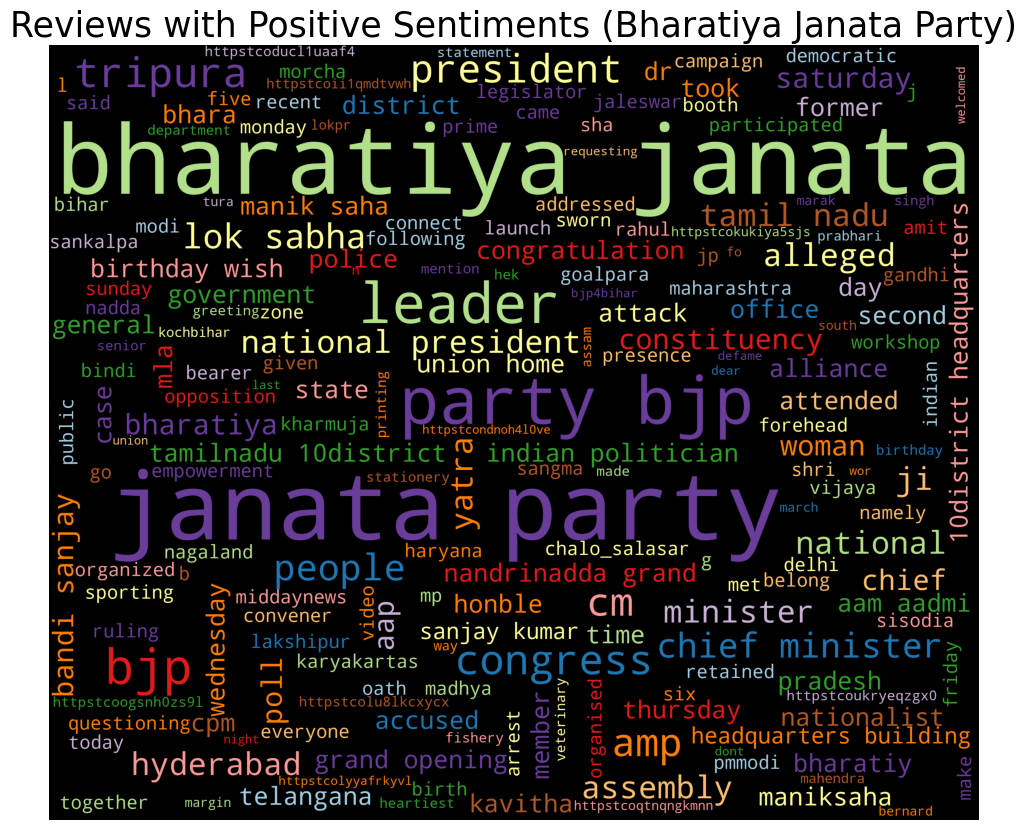

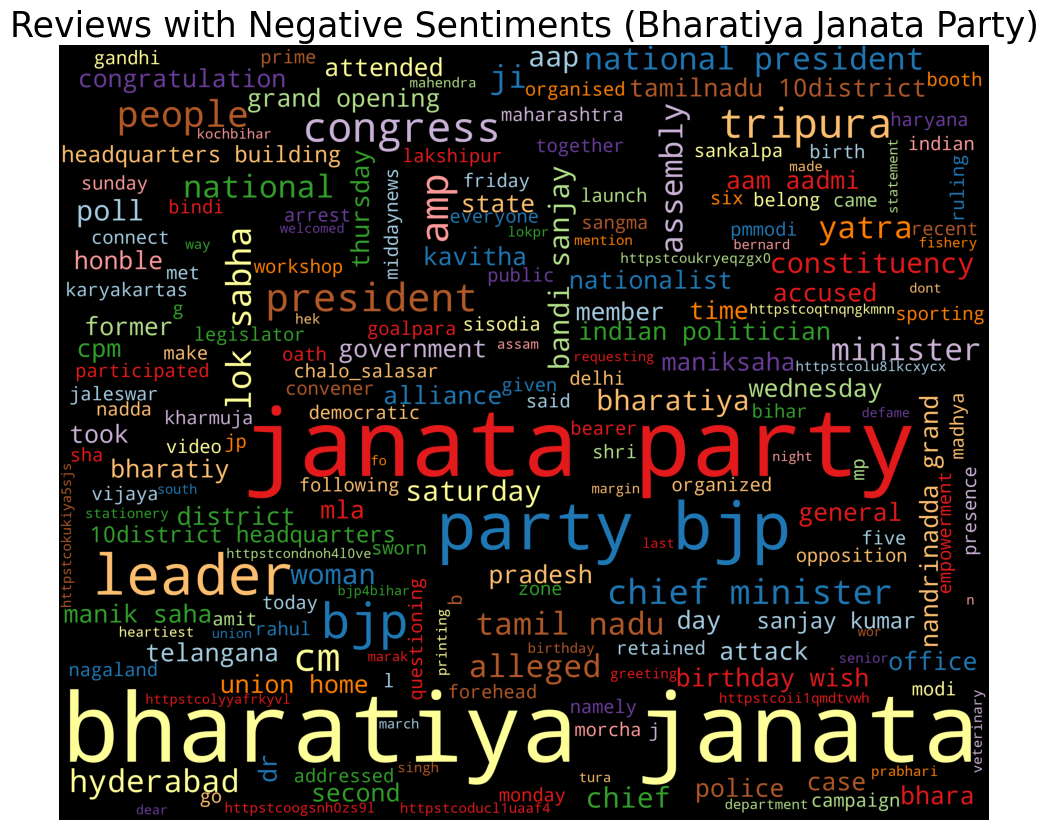

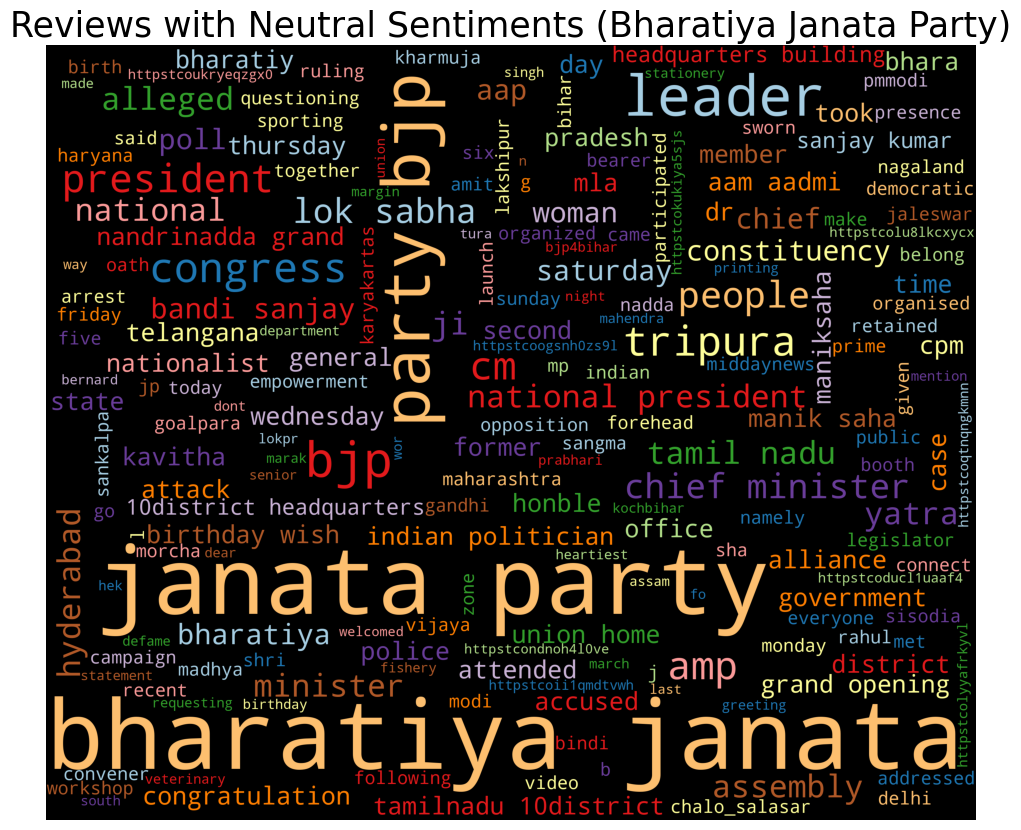

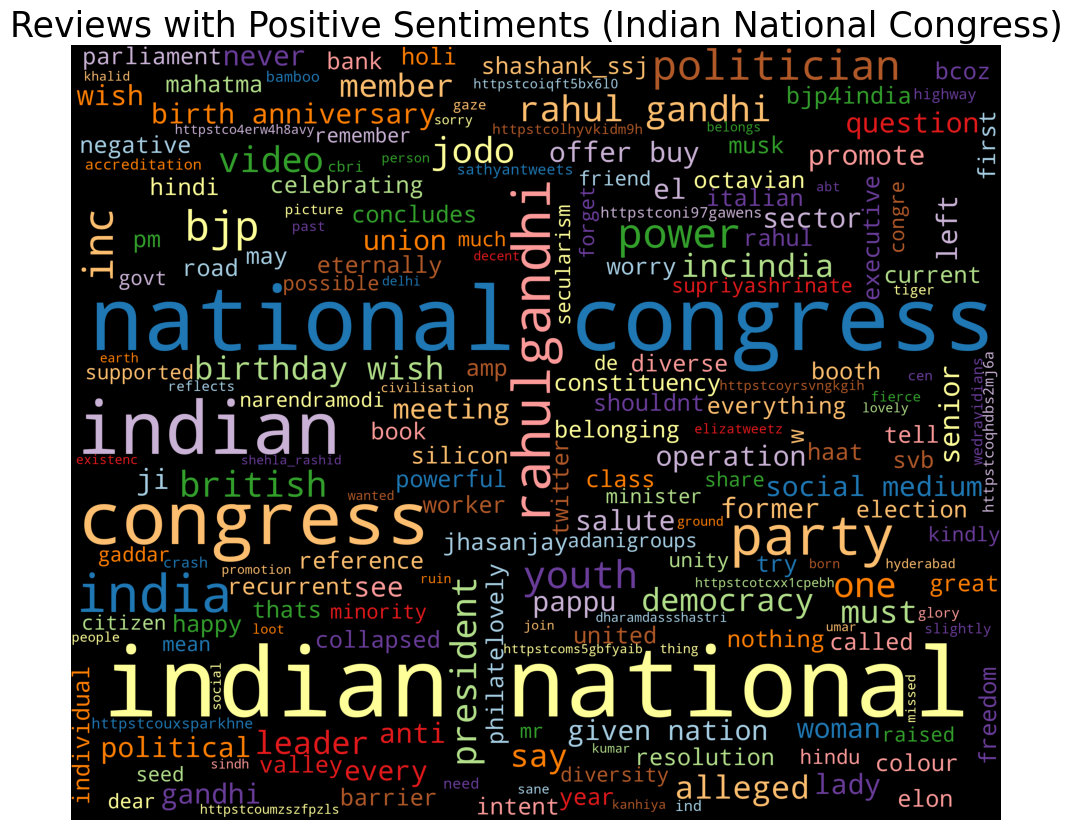

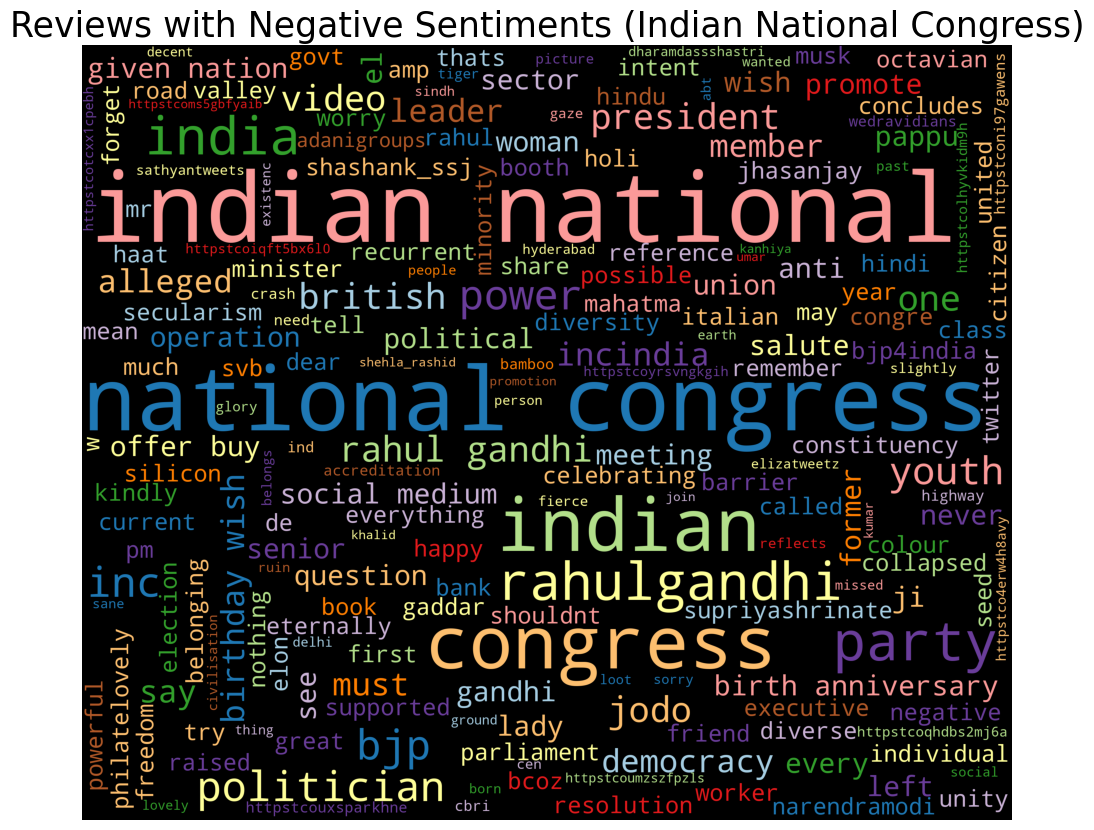

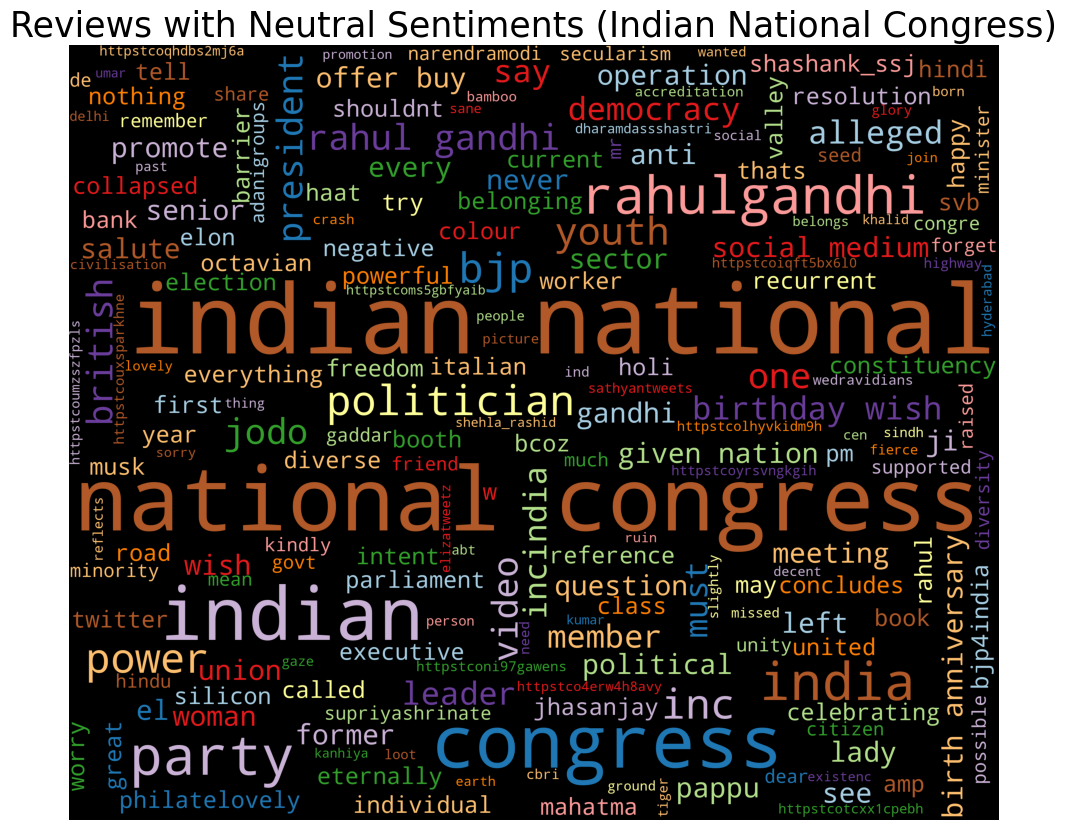

In [39]:
sentiment_coll = ['Positive','Negative','Neutral']
for party in df_coll.keys():
    for sentiment in sentiment_coll:
        new_df=df_coll[party][df_coll[party]['Sentiment']==sentiment]
        words = ' '.join(df_coll[party]['Clean_Tweet'])

        wordCloudPrint(words,sentiment,party)

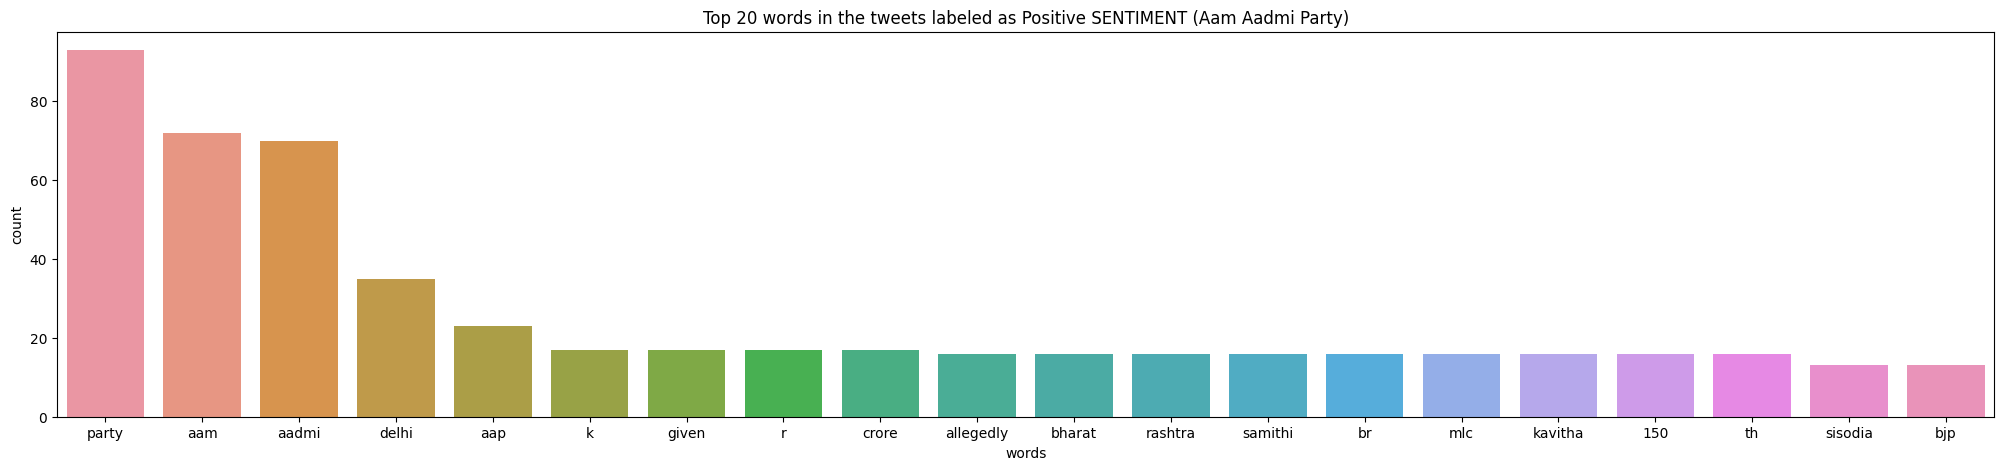

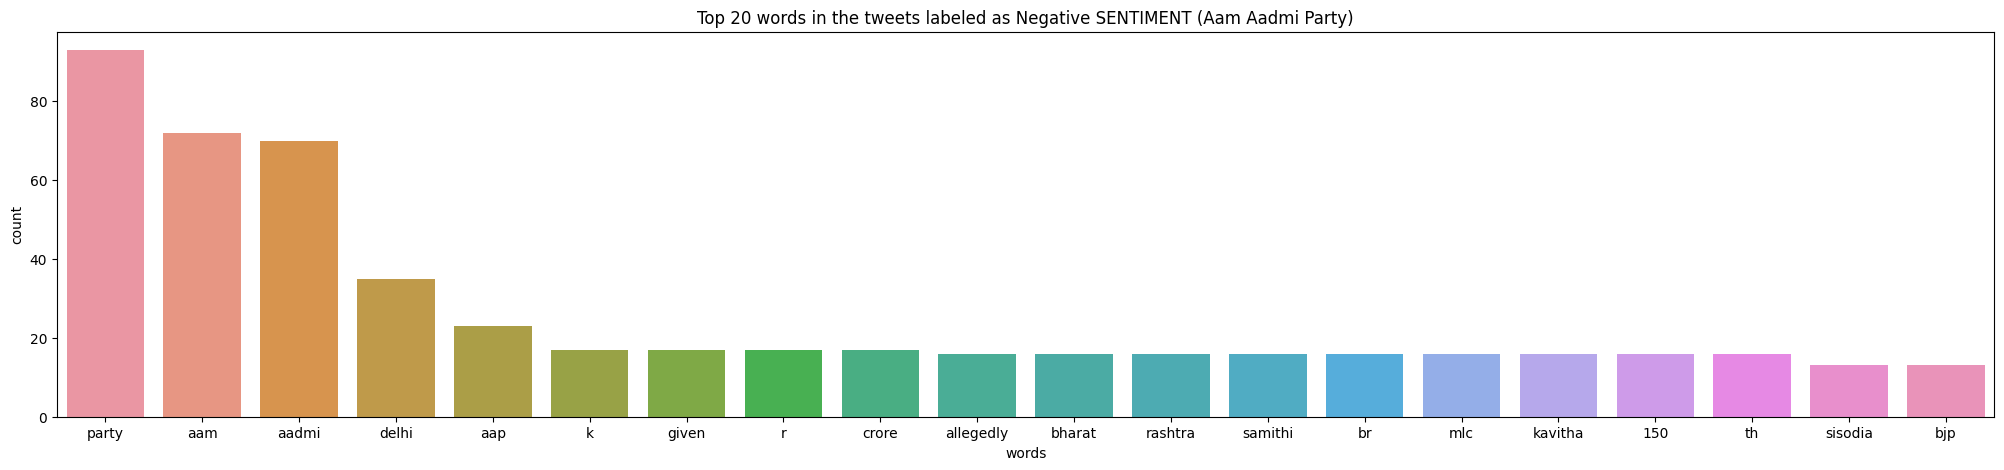

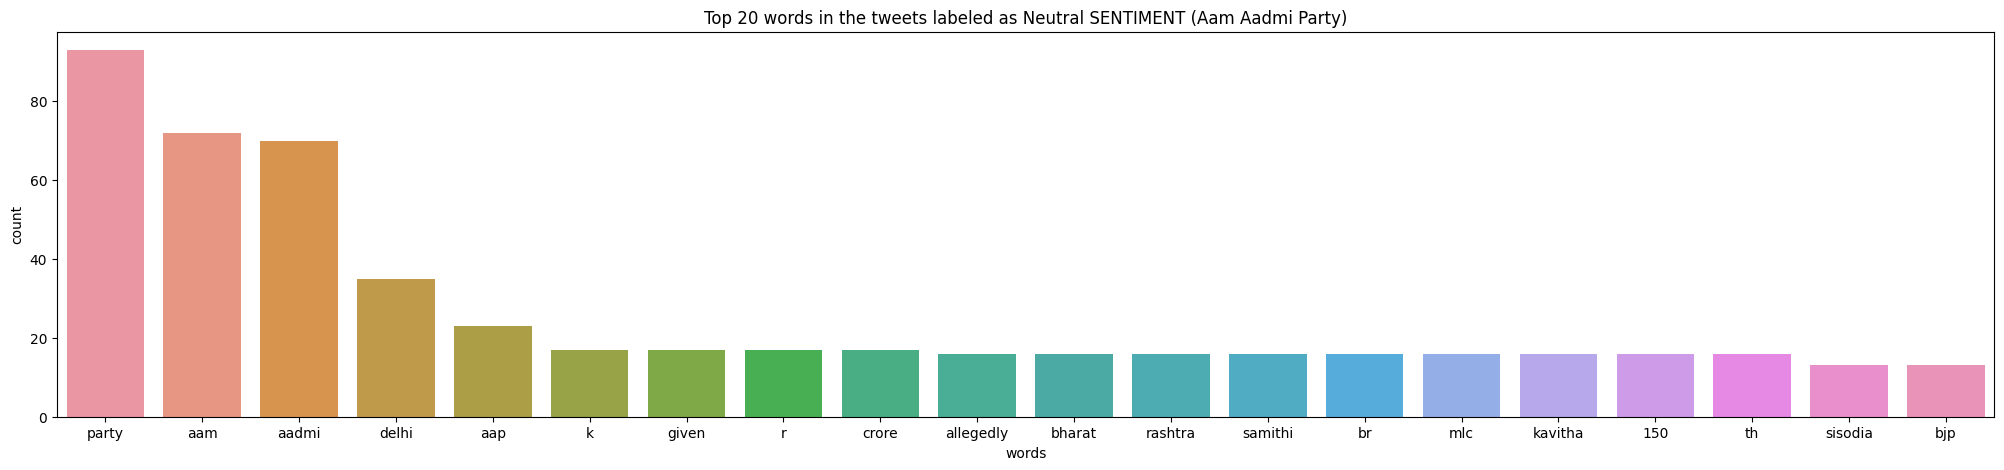

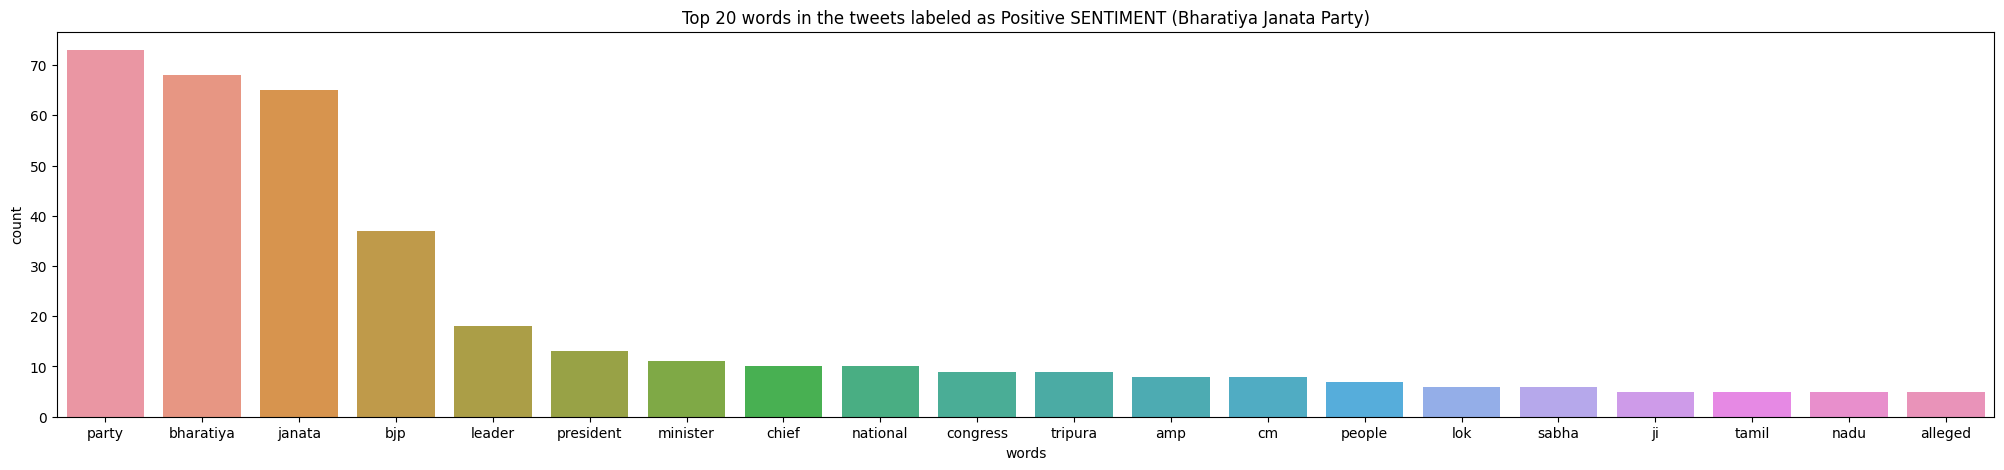

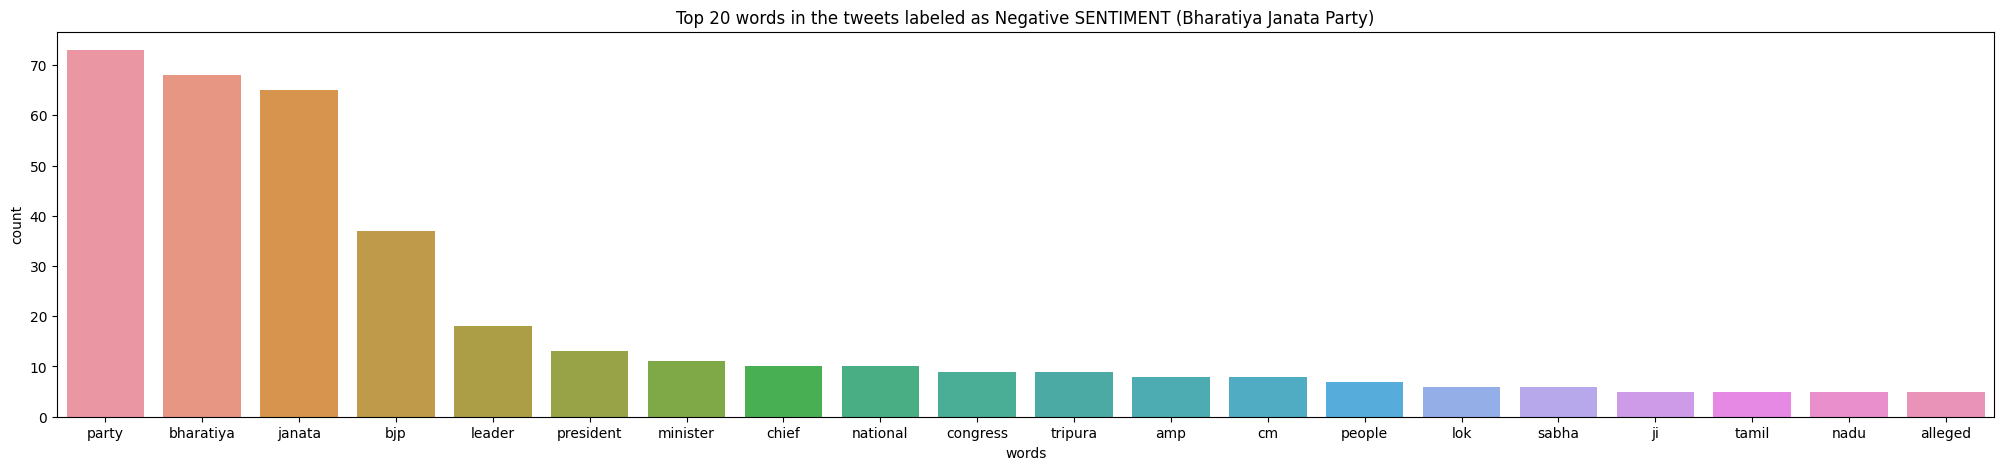

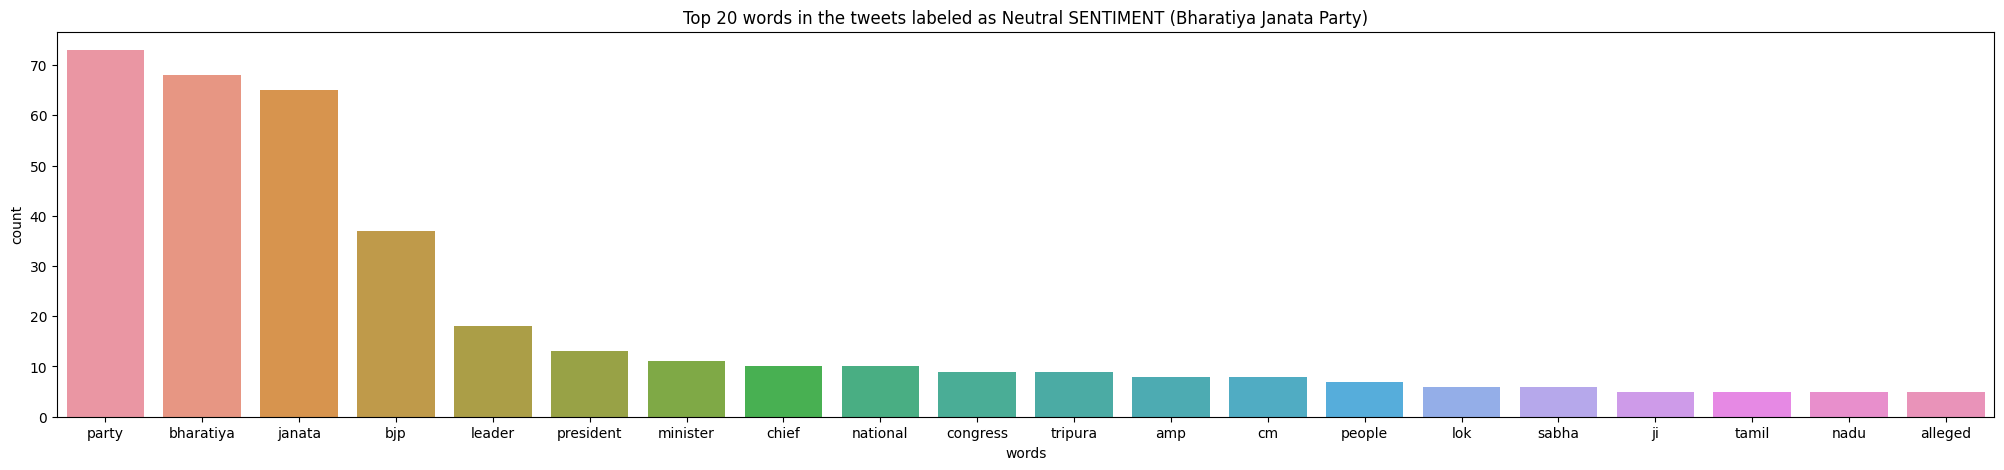

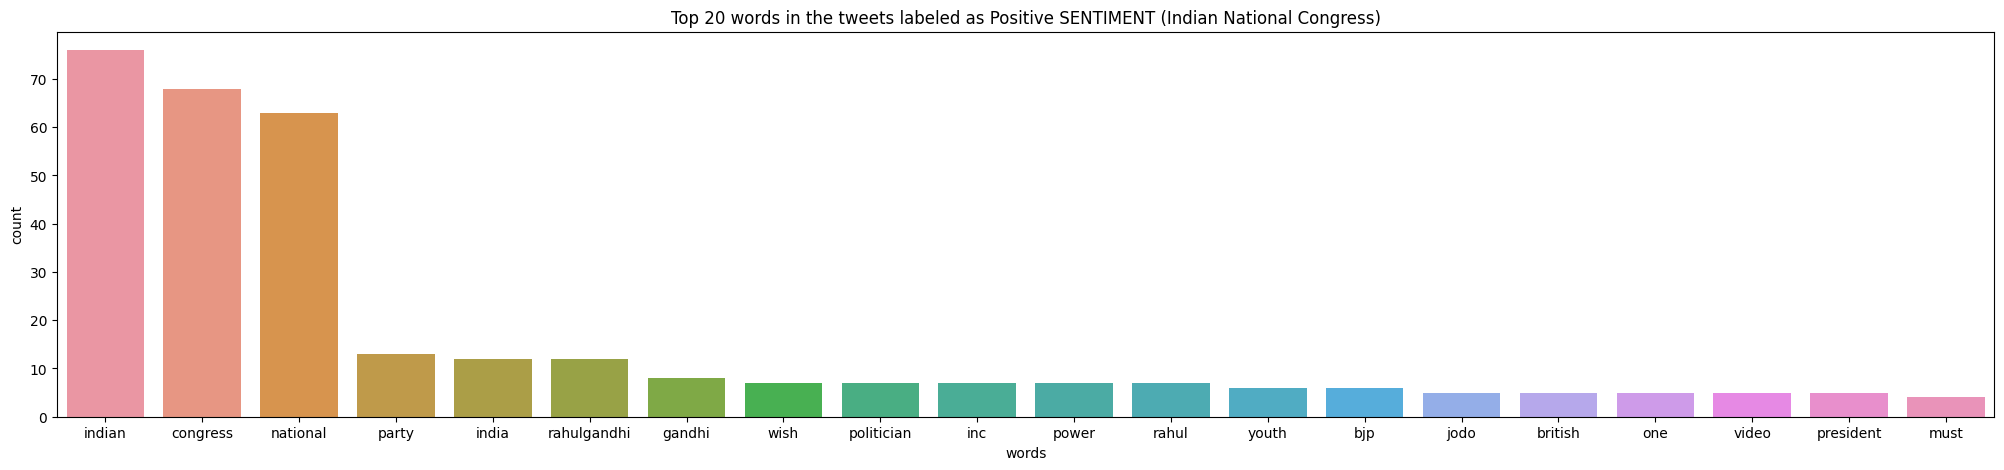

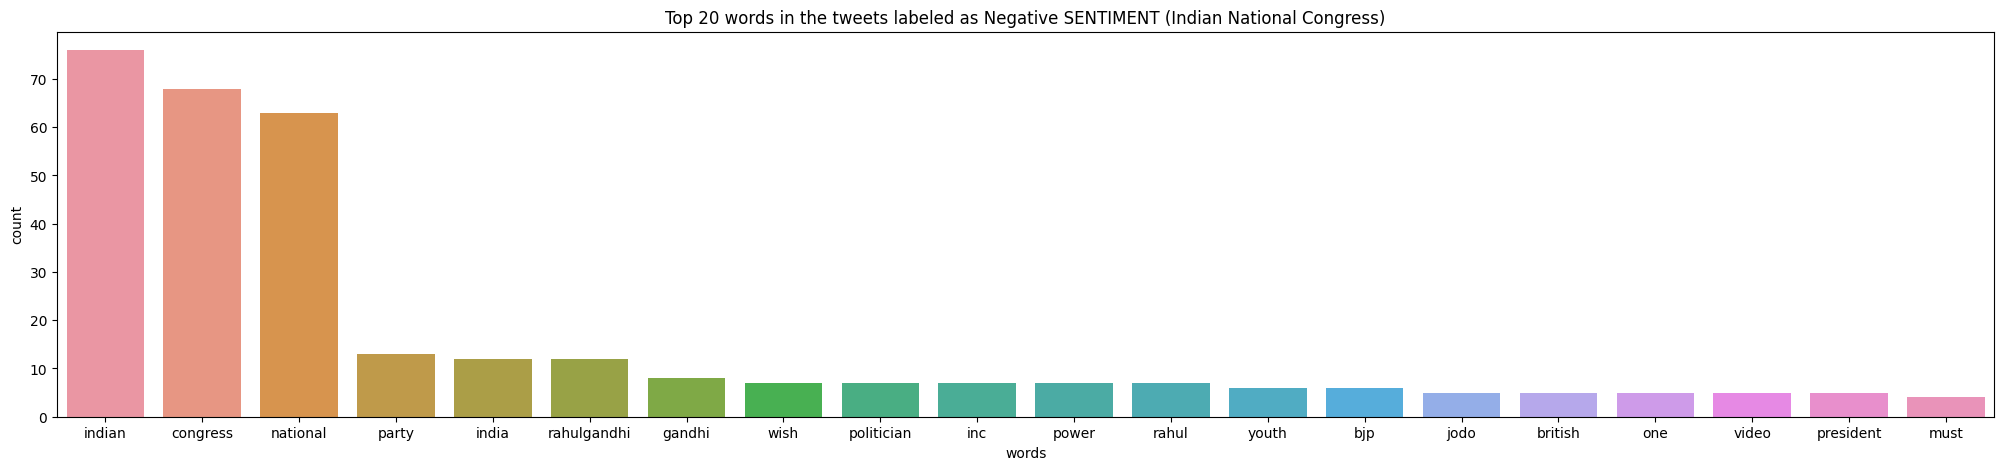

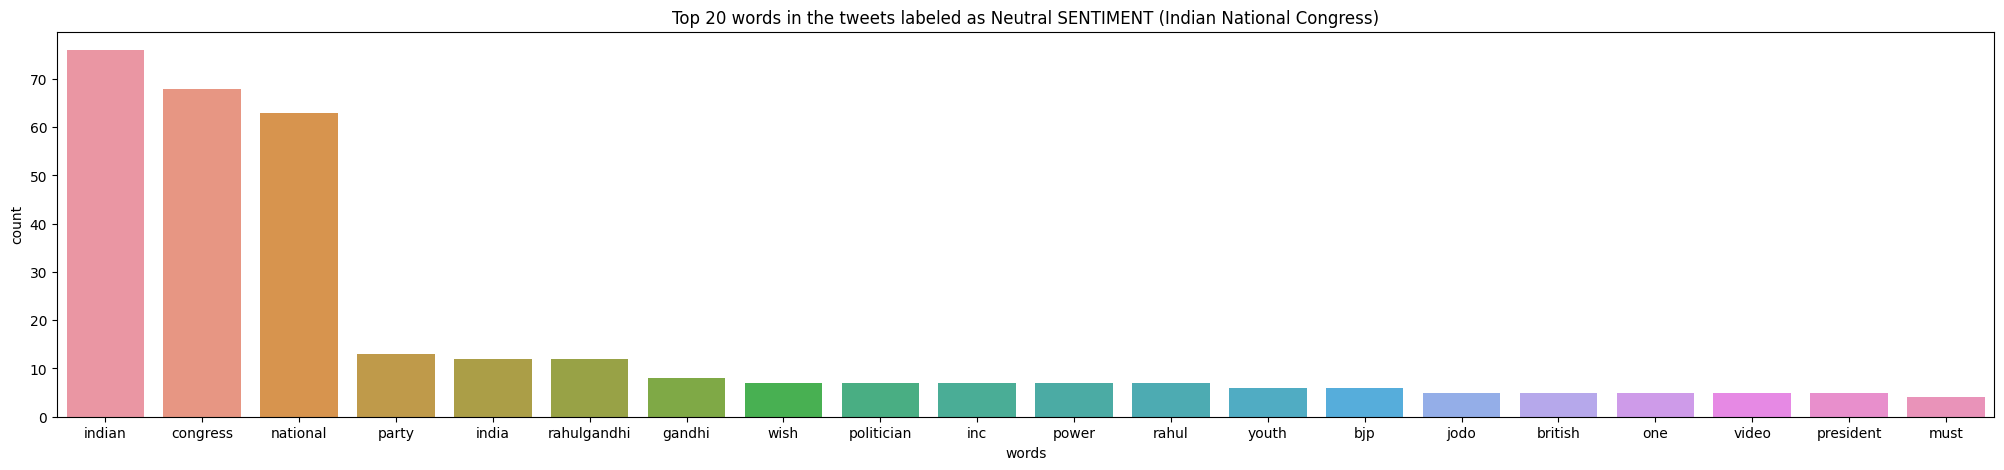

In [40]:
sentiment_coll = ['Positive','Negative','Neutral']
for party in df_coll.keys():
    for sentiment in sentiment_coll:
        new_df=df_coll[party][df_coll[party]['Sentiment']==sentiment]
        words = ' '.join(df_coll[party]['Clean_Tweet'])

        list_pos_words = [ x for x in words.split()]
        freq_dis_pos = nltk.FreqDist(list_pos_words)
        freq_dataframe = pd.DataFrame({'words': list(freq_dis_pos.keys()), 'count': list(freq_dis_pos.values())})
        freq_dataframe = freq_dataframe.nlargest(columns="count", n = 20)
        plt.figure(figsize=(25,5))
        ax = sns.barplot(data=freq_dataframe, x= "words", y = "count")
        ax.set(ylabel = 'count')
        plt.title('Top 20 words in the tweets labeled as '+sentiment+' SENTIMENT ('+party+')')
        plt.show()

In [41]:
for party in df_coll.keys():
    df_export = df_coll[party][["Clean_Tweet","Sentiment"]]
    df_export.to_csv(party+'.csv')

In [42]:
data = pd.DataFrame()

for party in df_coll.keys():
    if data.empty :
        data = df_coll[party][["Clean_Tweet","Sentiment"]]
    else:
        data = data.append(df_coll[party][["Clean_Tweet","Sentiment"]])

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\2748242603.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\2748242603.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [43]:
data

Clean_Tweet Sentiment
0   2015 swati maliwal appointed chair delhi commi...  Positive
1   enforcement directorate ed thursday march 9 ar...  Negative
2   statement come aam aadmi party aap raised obje...  Positive
3   sukeshchandrashekhar claimed along manishsisod...   Neutral
4   aam aadmi party launch monthlong membership dr...  Positive
..                                                ...       ...
90  former congress chief rahulgandhi claimed bjp ...   Neutral
91  tamilnadu congress committee president ksalagi...   Neutral
92  british flattered ancestor bjpsangh leader ind...  Positive
93  supriya shrinate madam chairperson social medi...   Neutral
94  indian_national_congress_party youth president...  Negative

[285 rows x 2 columns]

In [44]:
features = data.iloc[:, 0].values
labels = data.iloc[:, 1].values

In [45]:
labels, features

(array(['Positive', 'Negative', 'Positive', 'Neutral', 'Positive',
        'Positive', 'Negative', 'Neutral', 'Negative', 'Positive',
        'Negative', 'Neutral', 'Positive', 'Positive', 'Positive',
        'Positive', 'Positive', 'Positive', 'Positive', 'Neutral',
        'Neutral', 'Positive', 'Positive', 'Positive', 'Negative',
        'Positive', 'Positive', 'Positive', 'Neutral', 'Positive',
        'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
        'Positive', 'Positive', 'Neutral', 'Positive', 'Positive',
        'Positive', 'Positive', 'Positive', 'Negative', 'Negative',
        'Negative', 'Neutral', 'Positive', 'Positive', 'Positive',
        'Positive', 'Negative', 'Neutral', 'Positive', 'Positive',
        'Positive', 'Positive', 'Positive', 'Positive', 'Positive',
        'Positive', 'Positive', 'Negative', 'Positive', 'Neutral',
        'Positive', 'Positive', 'Neutral', 'Negative', 'Positive',
        'Positive', 'Neutral', 'Positive', 'Positive', 'Pos

In [46]:
features_pp = []
for i in range(0, len(features)):
    feature_pp = re.sub(r'\W', ' ', str(features[i]))
    feature_pp = re.sub(r'\s+[a-zA-Z]\s+', ' ', feature_pp)
    feature_pp = re.sub(r'\^[a-zA-Z]\s+', ' ', feature_pp)
    feature_pp = re.sub(r'\s+', ' ', feature_pp, flags=re.I)
    feature_pp = re.sub(r'^b\s+', '', feature_pp)
    feature_pp = feature_pp.lower()
    features_pp.append(feature_pp)

In [47]:
vectorizer = TfidfVectorizer(max_features=2500, 
    min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
features_pp = vectorizer.fit_transform(features_pp).toarray()

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    features_pp, labels, test_size=0.3, random_state=0)

In [49]:
X_train.view()

array([[0.        , 0.46109415, 0.45586585, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.3845251 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.32126864, 0.31762581, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

Logistic Regression

In [50]:
LogReg= LogisticRegression()
LogReg= LogReg.fit(X_train,y_train)
y_pred= LogReg.predict(X_test)

In [51]:
cm= confusion_matrix(y_test,y_pred)
print("Confusion Matrix: ",cm,sep='\n')

print("\nClassification Report")
print(classification_report(y_test,y_pred))

Confusion Matrix: 
[[ 0  4 11]
 [ 1  6 15]
 [ 1  2 46]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        15
     Neutral       0.50      0.27      0.35        22
    Positive       0.64      0.94      0.76        49

    accuracy                           0.60        86
   macro avg       0.38      0.40      0.37        86
weighted avg       0.49      0.60      0.52        86



In [52]:
#Performing 10-fold Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, features_pp, labels, cv=kfold, scoring=scoring)
LGA= results.mean()
LGA

0.6910098522167488

In [53]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [54]:
LGRA= multiclass_roc_auc_score(y_test,y_pred)
LGRA

0.5644801776906908

RandomForest

In [55]:
rf=RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train,y_train)
y_pred= rf.predict(X_test)

In [56]:
cm= confusion_matrix(y_test,y_pred)
print("Confusion Matrix: ",cm,sep='\n')

print("\nClassification Report")
print(classification_report(y_test,y_pred))

Confusion Matrix: 
[[ 4  5  6]
 [ 4 11  7]
 [ 6  5 38]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.29      0.27      0.28        15
     Neutral       0.52      0.50      0.51        22
    Positive       0.75      0.78      0.76        49

    accuracy                           0.62        86
   macro avg       0.52      0.51      0.52        86
weighted avg       0.61      0.62      0.61        86



In [57]:
#Performing 10-fold Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
modelCV = RandomForestClassifier(n_estimators=100)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, features_pp, labels, cv=kfold, scoring=scoring)
RDF= results.mean()
RDF

0.7088669950738916

In [58]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

In [59]:
RF= multiclass_roc_auc_score(y_test,y_pred)
RF

0.6489550748290688

Gradient Boosting

In [60]:
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train,y_train)
y_pred = gb_clf.predict(X_test)

In [61]:
cm= confusion_matrix(y_test,y_pred)
print("Confusion Matrix: ",cm,sep='\n')

print("\nClassification Report")
print(classification_report(y_test,y_pred))

Confusion Matrix: 
[[ 2  5  8]
 [ 5  9  8]
 [ 3  3 43]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.20      0.13      0.16        15
     Neutral       0.53      0.41      0.46        22
    Positive       0.73      0.88      0.80        49

    accuracy                           0.63        86
   macro avg       0.49      0.47      0.47        86
weighted avg       0.59      0.63      0.60        86



In [62]:
#Performing 10-fold Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
modelCV = GradientBoostingClassifier()
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, features_pp, labels, cv=kfold, scoring=scoring)
GDBA= results.mean()
GDBA

0.6667487684729064

In [63]:
GBA= multiclass_roc_auc_score(y_test,y_pred)
GBA

0.6249777956769907

Support Vector Machine

In [64]:
svc_clf=SVC(probability=True)
svc_clf.fit(X_train,y_train)
y_pred = svc_clf.predict(X_test)

In [65]:
cm= confusion_matrix(y_test,y_pred)
print("Confusion Matrix: ",cm,sep='\n')

print("\nClassification Report")
print(classification_report(y_test,y_pred))

Confusion Matrix: 
[[ 3  0 12]
 [ 2  3 17]
 [ 2  1 46]]

Classification Report
              precision    recall  f1-score   support

    Negative       0.43      0.20      0.27        15
     Neutral       0.75      0.14      0.23        22
    Positive       0.61      0.94      0.74        49

    accuracy                           0.60        86
   macro avg       0.60      0.43      0.42        86
weighted avg       0.62      0.60      0.53        86



In [66]:
#Performing 10-fold Cross Validation
kfold = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)
modelCV = svc_clf
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, features_pp, labels, cv=kfold, scoring=scoring)
SVM=results.mean()
SVM

0.6841133004926109

In [67]:
SVCA= multiclass_roc_auc_score(y_test,y_pred)
SVCA

0.56989872243582

In [68]:
Algorithms= ['LogisticRegression','RandomForest','GB','SVM']
AUC_ROC= [LGRA,RF,GBA,SVCA]
CV_Accuracy = [LGA, RDF, GDBA, SVM]
comp= pd.DataFrame([AUC_ROC,CV_Accuracy]).T
comp.set_index([Algorithms],inplace=True)
comp.columns=['AUC-ROC', 'CV_Accuracy']
comp

AUC-ROC  CV_Accuracy
LogisticRegression  0.564480     0.691010
RandomForest        0.648955     0.708867
GB                  0.624978     0.666749
SVM                 0.569899     0.684113

<AxesSubplot: title={'center': 'Model Comparison'}>

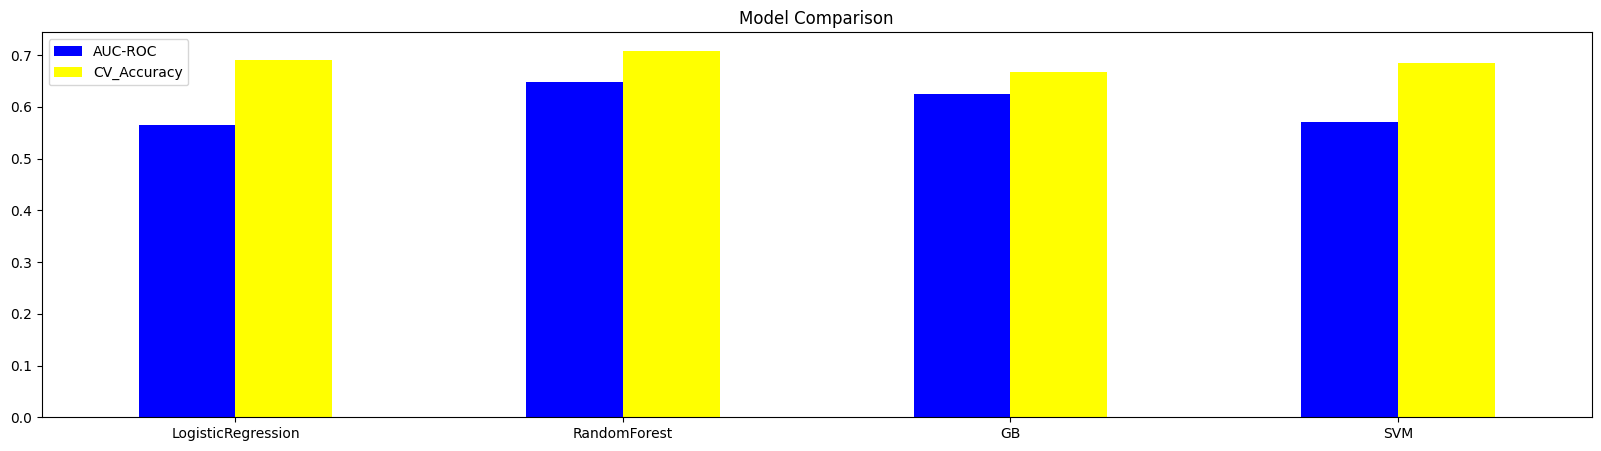

In [69]:
comp.plot(kind='bar',figsize=(20,5),rot=0,title='Model Comparison',color=['Blue','Yellow'])

# Transfer Learning (Word2Vec)

In [70]:
#Process and convert texts to a list of words
def text_to_word_list(text, remove_letters):
    text = remove_letters(text)
    text = str(text)
    text = text.lower()

    # Clean the text
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    text = url_pattern.sub(r'', text)
    text = re.sub('\S*@\S*\s?', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub("\'", "", text)
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r"\s{2,}", " ", text)

    text = word_tokenize(text)
    text = [spell(w) for w in (text)]
    text = [word for word in text if not word in stop]
    
    return text 

In [71]:
cln_data = pd.DataFrame()

In [72]:
cln_data = pd.DataFrame()

for party in df_coll.keys():
    if cln_data.empty :
        cln_data = df_coll[party].copy()
    else:
        cln_data = cln_data.append(df_coll[party])

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\2683381348.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\2683381348.py:7: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [73]:
cln_data

Tweet Party       State  \
0   In 2015, Swati Maliwal was appointed chair of ...   AAP       Assam   
1   The Enforcement Directorate (ED) on Thursday (...   AAP       Assam   
2   The statement comes after the Aam Aadmi Party ...   AAP       Assam   
3   #SukeshChandrashekhar claimed that along with ...   AAP       Delhi   
4   Aam Aadmi Party launches month-long membership...   AAP       Delhi   
..                                                ...   ...         ...   
90  Former #Congress chief #RahulGandhi claimed th...   INC  Tamil Nadu   
91  #TamilNadu #Congress Committee president #KSAl...   INC  Tamil Nadu   
92  The British who were flattered by the ancestor...   INC   Telangana   
93  Supriya Shrinate Madam Chairperson Social Medi...   INC   Telangana   
94  #Indian_National_Congress_Party Youth Presiden...   INC   Telangana   

     Latitude  Longitude                                        Clean_Tweet  \
0   26.407384  93.255130  2015 swati maliwal appointed chair delhi commi...   
1   26.407384  93.255130  enforcement directorate ed thursday march 9 ar...   
2   26.407384  93.255130  statement come aam aadmi party aap raised obje...   
3   28.651718  77.221939  sukeshchandrashekhar claimed along manishsisod...   
4   28.651718  77.221939  aam aadmi party launch monthlong membership dr...   
..        ...        ...                                                ...   
90  10.909433  78.366535  former congress chief rahulgandhi claimed bjp ...   
91  10.909433  78.366535  tamilnadu congress committee president ksalagi...   
92  17.849592  79.115166  british flattered ancestor bjpsangh leader ind...   
93  17.849592  79.115166  supriya shrinate madam chairperson social medi...   
94  17.849592  79.115166  indian_national_congress_party youth president...   

    Positive  Negative  Neutral  Compound Sentiment  
0      0.172     0.000    0.828    0.4019  Positive  
1      0.144     0.165    0.691   -0.1027  Negative  
2      0.250     0.000    0.750    0.4588  Positive  
3      0.000     0.000    1.000    0.0000   Neutral  
4      0.153     0.000    0.847    0.4019  Positive  
..       ...       ...      ...       ...       ...  
90     0.000     0.000    1.000    0.0000   Neutral  
91     0.000     0.000    1.000    0.0000   Neutral  
92     0.245     0.000    0.755    0.3818  Positive  
93     0.000     0.000    1.000    0.0000   Neutral  
94     0.000     0.404    0.596   -0.7269  Negative  

[285 rows x 11 columns]

In [74]:
cln_data = cln_data[cln_data.Sentiment != 'Neutral']

In [75]:
cln_data.Clean_Tweet = cln_data.Clean_Tweet.apply(lambda x: text_to_word_list(x, unidecode))

C:\Users\vedant\AppData\Local\Temp\ipykernel_25236\2611889042.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [76]:
cln_data_copy = cln_data.copy()
cln_data_copy = cln_data_copy[cln_data_copy.Clean_Tweet.str.len()>1]

In [77]:
cln_data_copy

Tweet Party        State  \
0   In 2015, Swati Maliwal was appointed chair of ...   AAP        Assam   
1   The Enforcement Directorate (ED) on Thursday (...   AAP        Assam   
2   The statement comes after the Aam Aadmi Party ...   AAP        Assam   
4   Aam Aadmi Party launches month-long membership...   AAP        Delhi   
5   The Aam Aadmi Party (AAP) will start a mega me...   AAP        Delhi   
..                                                ...   ...          ...   
83  @smitabarooah For Rahul Gandhi,if Congress los...   INC  Maharashtra   
84  @kalapirar @INCIndia @RahulGandhi Mungerilal k...   INC  Maharashtra   
87  The Indian National Congress wishes you all a ...   INC   Puducherry   
92  The British who were flattered by the ancestor...   INC    Telangana   
94  #Indian_National_Congress_Party Youth Presiden...   INC    Telangana   

     Latitude  Longitude                                        Clean_Tweet  \
0   26.407384  93.255130  [2015, swati, maliwal, appointed, chair, delhi...   
1   26.407384  93.255130  [enforcement, directorate, ed, thursday, march...   
2   26.407384  93.255130  [statement, come, aam, aadmi, party, aap, rais...   
4   28.651718  77.221939  [aam, aadmi, party, launch, monthlong, members...   
5   28.651718  77.221939  [aam, aadmi, party, aap, start, mega, membersh...   
..        ...        ...                                                ...   
83  18.906836  75.674158  [smitabarooah, rahul, gandhiif, congress, lose...   
84  18.906836  75.674158  [kalapirar, incindia, rahulgandhi, mungerilal,...   
87  10.915649  79.806949  [indian, national, congress, wish, happy, holi...   
92  17.849592  79.115166  [british, flattered, ancestor, bjpsangh, leade...   
94  17.849592  79.115166  [indian, national, congress, party, youth, pre...   

    Positive  Negative  Neutral  Compound Sentiment  
0      0.172     0.000    0.828    0.4019  Positive  
1      0.144     0.165    0.691   -0.1027  Negative  
2      0.250     0.000    0.750    0.4588  Positive  
4      0.153     0.000    0.847    0.4019  Positive  
5      0.293     0.000    0.707    0.6597  Positive  
..       ...       ...      ...       ...       ...  
83     0.000     0.187    0.813   -0.3182  Negative  
84     0.000     0.119    0.881   -0.2263  Negative  
87     0.529     0.000    0.471    0.8779  Positive  
92     0.245     0.000    0.755    0.3818  Positive  
94     0.000     0.404    0.596   -0.7269  Negative  

[229 rows x 11 columns]

In [78]:
text = [row for row in cln_data_copy.Clean_Tweet]

phrases = Phrases(text, min_count=1, progress_per=50000)
bigram = Phraser(phrases)
sentences = bigram[text]
sentences[1]

INFO - 06:00:45: collecting all words and their counts
INFO - 06:00:45: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 06:00:45: collected 3257 token types (unigram + bigrams) from a corpus of 3057 words and 229 sentences
INFO - 06:00:45: merged Phrases<3257 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 06:00:45: Phrases lifecycle event {'msg': 'built Phrases<3257 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000> in 0.01s', 'datetime': '2023-03-12T06:00:45.351414', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
INFO - 06:00:45: exporting phrases from Phrases<3257 vocab, min_count=1, threshold=10.0, max_vocab_size=40000000>
INFO - 06:00:45: FrozenPhrases lifecycle event {'msg': 'exported FrozenPhrases<220 phrases, min_count=1, threshold=10.0> from Phrases<3257 vocab, min_count=1, threshold=10.0, max_vocab_siz

['enforcement_directorate',
 'ed',
 'thursday',
 'march',
 '9',
 'arrested',
 'aam_aadmi',
 'party_aap',
 'leader_former',
 'delhi',
 'deput',
 'httpstcosgby87nhp7']

In [79]:
print(type(sentences))

<class 'gensim.interfaces.TransformedCorpus'>


In [80]:
w2v_model = Word2Vec(min_count=3,
                     window=4,
                     vector_size=300,
                     sample=1e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=multiprocessing.cpu_count()-1)

start = time()

w2v_model.build_vocab(sentences, progress_per=50000)

print('Time to build vocab: {} mins'.format(round((time() - start) / 60, 2)))

INFO - 06:00:45: Word2Vec lifecycle event {'params': 'Word2Vec<vocab=0, vector_size=300, alpha=0.03>', 'datetime': '2023-03-12T06:00:45.457415', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'created'}
INFO - 06:00:45: collecting all words and their counts
INFO - 06:00:45: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 06:00:45: collected 1374 word types from a corpus of 2457 raw words and 229 sentences
INFO - 06:00:45: Creating a fresh vocabulary
INFO - 06:00:45: Word2Vec lifecycle event {'msg': 'effective_min_count=3 retains 124 unique words (9.02% of original 1374, drops 1250)', 'datetime': '2023-03-12T06:00:45.468415', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'prepare_vocab'}
INFO - 06:00:45: Word2Vec lifecycle event {'ms

Time to build vocab: 0.0 mins


In [81]:
start = time()
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)
print('Time to train the model: {} mins'.format(round((time() - start) / 60, 2)))
w2v_model.init_sims(replace=True)

INFO - 06:00:45: Word2Vec lifecycle event {'msg': 'training model with 3 workers on 124 vocabulary and 300 features, using sg=0 hs=0 sample=1e-05 negative=20 window=4 shrink_windows=True', 'datetime': '2023-03-12T06:00:45.548415', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'train'}
INFO - 06:00:45: EPOCH 0: training on 2457 raw words (26 effective words) took 0.0s, 24909 effective words/s
INFO - 06:00:45: EPOCH 1: training on 2457 raw words (29 effective words) took 0.0s, 27735 effective words/s
INFO - 06:00:45: EPOCH 2: training on 2457 raw words (25 effective words) took 0.0s, 24660 effective words/s
INFO - 06:00:45: EPOCH 3: training on 2457 raw words (34 effective words) took 0.0s, 32901 effective words/s
INFO - 06:00:45: EPOCH 4: training on 2457 raw words (36 effective words) took 0.0s, 38420 effective words/s
INFO - 06:00:45: EPOCH 5: training on 2457 raw words

Time to train the model: 0.0 mins


In [82]:
w2v_model.save("word2vec.model")

INFO - 06:00:45: Word2Vec lifecycle event {'fname_or_handle': 'word2vec.model', 'separately': 'None', 'sep_limit': 10485760, 'ignore': frozenset(), 'datetime': '2023-03-12T06:00:45.852413', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'saving'}
INFO - 06:00:45: not storing attribute cum_table
INFO - 06:00:45: saved word2vec.model


In [83]:
word_vectors = Word2Vec.load("word2vec.model").wv

INFO - 06:00:45: loading Word2Vec object from word2vec.model
INFO - 06:00:45: loading wv recursively from word2vec.model.wv.* with mmap=None
INFO - 06:00:45: setting ignored attribute cum_table to None
INFO - 06:00:45: Word2Vec lifecycle event {'fname': 'word2vec.model', 'datetime': '2023-03-12T06:00:45.922415', 'gensim': '4.3.0', 'python': '3.10.1 (tags/v3.10.1:2cd268a, Dec  6 2021, 19:10:37) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19045-SP0', 'event': 'loaded'}


In [84]:
print(type(word_vectors))

<class 'gensim.models.keyedvectors.KeyedVectors'>


In [85]:
print(type(w2v_model))

<class 'gensim.models.word2vec.Word2Vec'>


In [86]:
model = KMeans(n_clusters=2, max_iter=100, random_state=True, n_init=50).fit(X=word_vectors.vectors.astype('double'))

In [87]:
word_vectors.similar_by_vector(model.cluster_centers_[1], topn=10, restrict_vocab=None)

[('indian_politician', 0.29024261236190796),
 ('number', 0.2653823494911194),
 ('rahul_gandhi', 0.2269396185874939),
 ('mp', 0.22230103611946106),
 ('bharatiya_janata', 0.2215365171432495),
 ('rahul', 0.21704034507274628),
 ('worker', 0.2163291871547699),
 ('woman', 0.21204863488674164),
 ('aam_aadmi', 0.20412838459014893),
 ('l', 0.2033461332321167)]

In [88]:
positive_cluster_index = 1
positive_cluster_center = model.cluster_centers_[positive_cluster_index]
negative_cluster_center = model.cluster_centers_[1-positive_cluster_index]

In [89]:
words = pd.DataFrame(word_vectors.index_to_key)
words.columns = ['words']
words['vectors'] = words.words.apply(lambda x: word_vectors[f'{x}'])
words['cluster'] = words.vectors.apply(lambda x: model.predict([np.array(x)]))
words.cluster = words.cluster.apply(lambda x: x[0])

In [90]:
words['cluster_value'] = [1 if i==positive_cluster_index else -1 for i in words.cluster]
words['closeness_score'] = words.apply(lambda x: 1/(model.transform([x.vectors]).min()), axis=1)
words['sentiment_coeff'] = words.closeness_score * words.cluster_value

In [91]:
words.head(10)

words                                            vectors  \
0             party  [-0.0060886135, 0.0032751723, 0.051844675, 0.0...   
1         aam_aadmi  [-0.08019792, 0.090480484, -0.0016788468, -0.0...   
2  bharatiya_janata  [0.08337511, -0.04569827, -0.0109532, 0.010317...   
3          congress  [-0.05320148, -0.06805121, -0.07964563, 0.0855...   
4   indian_national  [-0.01894802, -0.05133641, 0.09207004, -0.0906...   
5               bjp  [-0.06791642, 0.040760767, 0.020419074, 0.0703...   
6            leader  [0.10003534, -0.10025134, -0.06676025, 0.02898...   
7         k_kavitha  [0.013299703, 0.065283224, 0.0996547, 0.090450...   
8   rashtra_samithi  [-0.04972388, -0.0117837675, 0.03268723, -0.06...   
9           given_r  [0.020307945, 0.057567768, -0.020488996, 0.031...   

   cluster  cluster_value  closeness_score  sentiment_coeff  
0        0             -1         1.011871        -1.011871  
1        1              1         1.019207         1.019207  
2        1              1         1.021766         1.021766  
3        1              1         1.012697         1.012697  
4        1              1         0.997205         0.997205  
5        1              1         1.010049         1.010049  
6        1              1         1.013072         1.013072  
7        0             -1         1.005945        -1.005945  
8        1              1         1.009497         1.009497  
9        1              1         1.013235         1.013235

In [92]:
words[['words', 'sentiment_coeff']].to_csv('sentiment_dictionary.csv', index=False)

In [93]:
sentiment_dict = words.set_index('words')['sentiment_coeff'].to_dict()

In [94]:
data_export = cln_data.copy()
data_export['old_Clean_Tweet'] = data_export.Clean_Tweet
data_export.old_Clean_Tweet = data_export.old_Clean_Tweet.str.join(' ')
data_export.Clean_Tweet = data_export.Clean_Tweet.apply(lambda x: ' '.join(bigram[x]))

In [95]:
data_export[['Clean_Tweet', 'Sentiment','Party','State','Latitude','Longitude']].to_csv('cleaned_dataset.csv', index=False)

In [96]:
data_export

Tweet Party        State  \
0   In 2015, Swati Maliwal was appointed chair of ...   AAP        Assam   
1   The Enforcement Directorate (ED) on Thursday (...   AAP        Assam   
2   The statement comes after the Aam Aadmi Party ...   AAP        Assam   
4   Aam Aadmi Party launches month-long membership...   AAP        Delhi   
5   The Aam Aadmi Party (AAP) will start a mega me...   AAP        Delhi   
..                                                ...   ...          ...   
83  @smitabarooah For Rahul Gandhi,if Congress los...   INC  Maharashtra   
84  @kalapirar @INCIndia @RahulGandhi Mungerilal k...   INC  Maharashtra   
87  The Indian National Congress wishes you all a ...   INC   Puducherry   
92  The British who were flattered by the ancestor...   INC    Telangana   
94  #Indian_National_Congress_Party Youth Presiden...   INC    Telangana   

     Latitude  Longitude                                        Clean_Tweet  \
0   26.407384  93.255130  2015 swati maliwal appointed chair delhi_commi...   
1   26.407384  93.255130  enforcement_directorate ed thursday march 9 ar...   
2   26.407384  93.255130  statement_come aam_aadmi party_aap raised_obje...   
4   28.651718  77.221939  aam_aadmi party launch monthlong membership_dr...   
5   28.651718  77.221939  aam_aadmi party_aap start mega_membership driv...   
..        ...        ...                                                ...   
83  18.906836  75.674158  smitabarooah rahul gandhiif congress loses nat...   
84  18.906836  75.674158  kalapirar incindia rahulgandhi mungerilal ke h...   
87  10.915649  79.806949  indian_national congress wish_happy holi_celeb...   
92  17.849592  79.115166  british flattered ancestor bjpsangh leader ind...   
94  17.849592  79.115166  indian_national congress party youth president...   

    Positive  Negative  Neutral  Compound Sentiment  \
0      0.172     0.000    0.828    0.4019  Positive   
1      0.144     0.165    0.691   -0.1027  Negative   
2      0.250     0.000    0.750    0.4588  Positive   
4      0.153     0.000    0.847    0.4019  Positive   
5      0.293     0.000    0.707    0.6597  Positive   
..       ...       ...      ...       ...       ...   
83     0.000     0.187    0.813   -0.3182  Negative   
84     0.000     0.119    0.881   -0.2263  Negative   
87     0.529     0.000    0.471    0.8779  Positive   
92     0.245     0.000    0.755    0.3818  Positive   
94     0.000     0.404    0.596   -0.7269  Negative   

                                      old_Clean_Tweet  
0   2015 swati maliwal appointed chair delhi commi...  
1   enforcement directorate ed thursday march 9 ar...  
2   statement come aam aadmi party aap raised obje...  
4   aam aadmi party launch monthlong membership dr...  
5   aam aadmi party aap start mega membership driv...  
..                                                ...  
83  smitabarooah rahul gandhiif congress loses nat...  
84  kalapirar incindia rahulgandhi mungerilal ke h...  
87  indian national congress wish happy holi celeb...  
92  british flattered ancestor bjpsangh leader ind...  
94  indian national congress party youth president...  

[229 rows x 12 columns]

In [97]:
final_file = pd.read_csv('cleaned_dataset.csv')
file_weighting = final_file.copy()

In [98]:
tfidf = TfidfVectorizer(tokenizer=lambda y: y.split(), norm=None)
tfidf.fit(file_weighting.Clean_Tweet)
features = pd.Series(tfidf.get_feature_names_out())
transformed = tfidf.transform(file_weighting.Clean_Tweet)

f:\vedant\Courses\BITS Data Science\Sem 4\Application\.venv\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



In [99]:
def create_tfidf_dictionary(x, transformed_file, features):
    '''
    create dictionary for each input sentence x, where each word has assigned its tfidf score
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer

    '''
    vector_coo = transformed_file[x.name].tocoo()
    vector_coo.col = features.iloc[vector_coo.col].values
    dict_from_coo = dict(zip(vector_coo.col, vector_coo.data))
    return dict_from_coo

def replace_tfidf_words(x, transformed_file, features):
    '''
    replacing each word with it's calculated tfidf dictionary with scores of each word
    x - row of dataframe, containing sentences, and their indexes,
    transformed_file - all sentences transformed with TfidfVectorizer
    features - names of all words in corpus used in TfidfVectorizer
    '''
    dictionary = create_tfidf_dictionary(x, transformed_file, features)   
    return list(map(lambda y:dictionary[f'{y}'], x.Clean_Tweet.split()))

In [100]:
%%time
replaced_tfidf_scores = file_weighting.apply(lambda x: replace_tfidf_words(x, transformed, features), axis=1)#this step takes around 3-4 minutes minutes to calculate

CPU times: total: 78.1 ms
Wall time: 66 ms


In [101]:
def replace_sentiment_words(word, sentiment_dict):
    '''
    replacing each word with its associated sentiment score from sentiment dict
    '''
    try:
        out = sentiment_dict[word]
    except KeyError:
        out = 0
    return out

In [102]:
replaced_closeness_scores = file_weighting.Clean_Tweet.apply(lambda x: list(map(lambda y: replace_sentiment_words(y, sentiment_dict), x.split())))

In [103]:
file_weighting

Clean_Tweet Sentiment Party  \
0    2015 swati maliwal appointed chair delhi_commi...  Positive   AAP   
1    enforcement_directorate ed thursday march 9 ar...  Negative   AAP   
2    statement_come aam_aadmi party_aap raised_obje...  Positive   AAP   
3    aam_aadmi party launch monthlong membership_dr...  Positive   AAP   
4    aam_aadmi party_aap start mega_membership driv...  Positive   AAP   
..                                                 ...       ...   ...   
224  smitabarooah rahul gandhiif congress loses nat...  Negative   INC   
225  kalapirar incindia rahulgandhi mungerilal ke h...  Negative   INC   
226  indian_national congress wish_happy holi_celeb...  Positive   INC   
227  british flattered ancestor bjpsangh leader ind...  Positive   INC   
228  indian_national congress party youth president...  Negative   INC   

           State   Latitude  Longitude  
0          Assam  26.407384  93.255130  
1          Assam  26.407384  93.255130  
2          Assam  26.407384  93.255130  
3          Delhi  28.651718  77.221939  
4          Delhi  28.651718  77.221939  
..           ...        ...        ...  
224  Maharashtra  18.906836  75.674158  
225  Maharashtra  18.906836  75.674158  
226   Puducherry  10.915649  79.806949  
227    Telangana  17.849592  79.115166  
228    Telangana  17.849592  79.115166  

[229 rows x 6 columns]

In [104]:
replacement_df = pd.DataFrame(data=[replaced_closeness_scores, replaced_tfidf_scores, file_weighting.Clean_Tweet, file_weighting.Sentiment,file_weighting.Party,file_weighting.State,file_weighting.Latitude,file_weighting.Longitude]).T

In [105]:
replacement_df

Clean_Tweet  \
0    [0, 0, 0, 0, 0, 0, 1.020368753123683, 1.019207...   
1    [0, -1.025205082064594, 0.9926437658537733, 1....   
2    [0, 1.019207022764559, 0.9952603464585064, 0, ...   
3    [1.019207022764559, -1.0118714109427354, 0, 0,...   
4    [1.019207022764559, 0.9952603464585064, 0, 0, ...   
..                                                 ...   
224  [0, 1.0211028405091207, 0, 1.0126974835153384,...   
225  [0, 0, -1.0045791386632623, 0, 0, 0, 0, 0, 0, ...   
226  [0.9972048391322347, 1.0126974835153384, 0, 0,...   
227  [1.008017379161801, 0, 0, 0, 1.013071925038855...   
228  [0.9972048391322347, 1.0126974835153384, -1.01...   

                                             Unnamed 0  \
0    [5.74493212836325, 5.339467020255086, 5.744932...   
1    [5.339467020255086, 5.051784947803305, 4.64631...   
2    [5.339467020255086, 2.2484245668967695, 3.6654...   
3    [2.2484245668967695, 1.5552773863368246, 5.744...   
4    [2.2484245668967695, 3.665490586683414, 5.7449...   
..                                                 ...   
224  [5.74493212836325, 5.051784947803305, 5.744932...   
225  [5.74493212836325, 5.339467020255086, 4.492169...   
226  [2.8827312474337816, 2.653889675004934, 5.3394...   
227  [5.051784947803305, 5.74493212836325, 5.744932...   
228  [2.8827312474337816, 2.653889675004934, 1.5552...   

                                           Clean_Tweet Sentiment Party  \
0    2015 swati maliwal appointed chair delhi_commi...  Positive   AAP   
1    enforcement_directorate ed thursday march 9 ar...  Negative   AAP   
2    statement_come aam_aadmi party_aap raised_obje...  Positive   AAP   
3    aam_aadmi party launch monthlong membership_dr...  Positive   AAP   
4    aam_aadmi party_aap start mega_membership driv...  Positive   AAP   
..                                                 ...       ...   ...   
224  smitabarooah rahul gandhiif congress loses nat...  Negative   INC   
225  kalapirar incindia rahulgandhi mungerilal ke h...  Negative   INC   
226  indian_national congress wish_happy holi_celeb...  Positive   INC   
227  british flattered ancestor bjpsangh leader ind...  Positive   INC   
228  indian_national congress party youth president...  Negative   INC   

           State   Latitude  Longitude  
0          Assam  26.407384   93.25513  
1          Assam  26.407384   93.25513  
2          Assam  26.407384   93.25513  
3          Delhi  28.651718  77.221939  
4          Delhi  28.651718  77.221939  
..           ...        ...        ...  
224  Maharashtra  18.906836  75.674158  
225  Maharashtra  18.906836  75.674158  
226   Puducherry  10.915649  79.806949  
227    Telangana  17.849592  79.115166  
228    Telangana  17.849592  79.115166  

[229 rows x 8 columns]

In [106]:
replacement_df.columns = ['sentiment_coeff', 'tfidf_scores', 'Tweet', 'sentiment','Party','State','Latitude','Longitude']
replacement_df['sentiment_rate'] = replacement_df.apply(lambda x: np.array(x.loc['sentiment_coeff']) @ np.array(x.loc['tfidf_scores']), axis=1)
replacement_df['prediction'] = (replacement_df.sentiment_rate>0).astype('int8')
replacement_df['sentiment'] = [1 if i=='Positive' else 0 for i in replacement_df.sentiment]

In [107]:
replacement_df

sentiment_coeff  \
0    [0, 0, 0, 0, 0, 0, 1.020368753123683, 1.019207...   
1    [0, -1.025205082064594, 0.9926437658537733, 1....   
2    [0, 1.019207022764559, 0.9952603464585064, 0, ...   
3    [1.019207022764559, -1.0118714109427354, 0, 0,...   
4    [1.019207022764559, 0.9952603464585064, 0, 0, ...   
..                                                 ...   
224  [0, 1.0211028405091207, 0, 1.0126974835153384,...   
225  [0, 0, -1.0045791386632623, 0, 0, 0, 0, 0, 0, ...   
226  [0.9972048391322347, 1.0126974835153384, 0, 0,...   
227  [1.008017379161801, 0, 0, 0, 1.013071925038855...   
228  [0.9972048391322347, 1.0126974835153384, -1.01...   

                                          tfidf_scores  \
0    [5.74493212836325, 5.339467020255086, 5.744932...   
1    [5.339467020255086, 5.051784947803305, 4.64631...   
2    [5.339467020255086, 2.2484245668967695, 3.6654...   
3    [2.2484245668967695, 1.5552773863368246, 5.744...   
4    [2.2484245668967695, 3.665490586683414, 5.7449...   
..                                                 ...   
224  [5.74493212836325, 5.051784947803305, 5.744932...   
225  [5.74493212836325, 5.339467020255086, 4.492169...   
226  [2.8827312474337816, 2.653889675004934, 5.3394...   
227  [5.051784947803305, 5.74493212836325, 5.744932...   
228  [2.8827312474337816, 2.653889675004934, 1.5552...   

                                                 Tweet  sentiment Party  \
0    2015 swati maliwal appointed chair delhi_commi...          1   AAP   
1    enforcement_directorate ed thursday march 9 ar...          0   AAP   
2    statement_come aam_aadmi party_aap raised_obje...          1   AAP   
3    aam_aadmi party launch monthlong membership_dr...          1   AAP   
4    aam_aadmi party_aap start mega_membership driv...          1   AAP   
..                                                 ...        ...   ...   
224  smitabarooah rahul gandhiif congress loses nat...          0   INC   
225  kalapirar incindia rahulgandhi mungerilal ke h...          0   INC   
226  indian_national congress wish_happy holi_celeb...          1   INC   
227  british flattered ancestor bjpsangh leader ind...          1   INC   
228  indian_national congress party youth president...          0   INC   

           State   Latitude  Longitude  sentiment_rate  prediction  
0          Assam  26.407384   93.25513        4.707732           1  
1          Assam  26.407384   93.25513       10.959610           1  
2          Assam  26.407384   93.25513        5.976522           1  
3          Delhi  28.651718  77.221939       10.626953           1  
4          Delhi  28.651718  77.221939        9.296021           1  
..           ...        ...        ...             ...         ...  
224  Maharashtra  18.906836  75.674158       -1.580760           0  
225  Maharashtra  18.906836  75.674158        0.019524           1  
226   Puducherry  10.915649  79.806949        1.442949           1  
227    Telangana  17.849592  79.115166        9.052974           1  
228    Telangana  17.849592  79.115166        9.722324           1  

[229 rows x 10 columns]

In [108]:
predicted_classes = replacement_df.prediction
y_test = replacement_df.sentiment

conf_matrix = pd.DataFrame(confusion_matrix(replacement_df.sentiment, replacement_df.prediction))
print('Confusion Matrix')
display(conf_matrix)

test_scores = accuracy_score(y_test,predicted_classes), precision_score(y_test, predicted_classes), recall_score(y_test, predicted_classes), f1_score(y_test, predicted_classes)

print('\n \n Scores')
scores = pd.DataFrame(data=[test_scores])
scores.columns = ['accuracy', 'precision', 'recall', 'f1']
scores = scores.T
scores.columns = ['scores']
display(scores)

Confusion Matrix


0    1
0  17   24
1  59  129


 
 Scores


scores
accuracy   0.637555
precision  0.843137
recall     0.686170
f1         0.756598

In [109]:
result_export = replacement_df.copy()
result_export['sentiment'] = ['Positive' if i==1 else 'Negative' for i in result_export.sentiment]
result_export['prediction'] = ['Positive' if i==1 else 'Negative' for i in result_export.prediction]
result_export[['Tweet', 'sentiment','Party','State','Latitude','Longitude','prediction']].to_csv('result_dataset.csv', index=False)

In [110]:
os.system('jupyter nbconvert --to html MainApplication.ipynb')

0